# Information

- Интересные записки и кейс решения регрессии.


For more information => https://www.linkedin.com/pulse/kolmogorov-arnold-networks-kan-novel-approach-neural-network-karaka%25C5%259F-5uzsf/?trackingId=upcjYlhgRkqxm%2FgwAG%2Fm8Q%3D%3D

# Import Libraries

In [1]:
!pip install git+https://github.com/KindXiaoming/pykan.git > None # None чтобы не видеть огромного вывода, что библиотека загружается

  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-mkr84nc4


In [2]:
import torch
from kan import KAN

import random
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

**Эту ячейку запускать обязательно всегда перед началом работы, иначе значения гиперпараметров и самих метрик будут скакать даже при одинаковых цифрах**

In [3]:
# Фиксация случайных начальных условий
def seed_everything(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(1984)

# Data Preparation

In [4]:
df = pd.read_csv("/content/bias_param_0507_OUT.csv")

In [5]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1']) # удалим столбцы с индексами
df.info() # должеы быть столбцы от 0 до 37

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 38 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   area/volume                                 979 non-null    float64
 1   h_range_max_koe                             979 non-null    float64
 2   Tc                                          979 non-null    float64
 3   temperature_k                               979 non-null    float64
 4   sat_em_g                                    979 non-null    float64
 5   coer_oe                                     979 non-null    float64
 6   mr (emu/g)                                  979 non-null    float64
 7   exc_bias_oe                                 979 non-null    float64
 8   exc_dir                                     979 non-null    float64
 9   ver_shift_emu_g                             979 non-null    float64
 10  ver_s_dir     

In [6]:
# Проверим данные
df.describe()

,area/volume,h_range_max_koe,Tc,temperature_k,sat_em_g,coer_oe,mr (emu/g),exc_bias_oe,exc_dir,ver_shift_emu_g,...,core_sum_vec,core_sum_work_function,shell_sum_vec,shell_sum_work_function,core_pauling_electronegativity_difference,core_vec_difference,core_work_function_difference,shell_pauling_electronegativity_difference,shell_vec_difference,shell_work_function_difference
count,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,...,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,9.790000e+02,979.000000
mean,0.218317,36.457692,788.942901,72.999387,415.698464,2279.340897,13.128177,318.628186,0.141502,1.259763,...,698.794157,270.812372,539.941647,176.314782,2.290421,1.526309,8.942621,2.255265,1.511955e+00,8.086343
std,0.253926,23.634419,349.454907,110.867074,4974.751928,4053.992359,18.173922,405.794171,0.343329,4.774476,...,173.442290,147.822071,307.302545,124.118630,1.602428,1.355539,6.540183,1.502012,1.309873e+00,5.453118
min,0.003000,0.100000,30.000000,1.800000,0.000087,0.600000,0.000027,0.007500,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.220446e-16,0.000000
25%,0.079302,20.000000,643.000000,5.000000,7.245000,316.500000,0.560000,31.500000,0.000000,0.000000,...,621.428600,180.000000,400.000000,89.500000,0.052172,0.000000,0.117858,0.079156,-2.220446e-16,0.000000
50%,0.150000,30.000000,809.800000,10.000000,26.353000,844.300000,6.200000,127.295000,0.000000,0.067000,...,700.000000,216.428600,683.166700,201.428600,2.860376,1.495174,10.000000,2.859813,1.443376e+00,10.000000
75%,0.253787,50.000000,860.000000,100.000000,50.550000,2188.424500,20.225000,473.310000,0.000000,0.929785,...,800.000000,470.000000,750.000000,250.000000,3.128237,2.500000,12.247450,2.932331,2.037707e+00,11.547010
max,2.000000,100.000000,1661.000000,608.000000,106600.000000,59144.000000,247.960000,1670.900000,1.000000,111.360000,...,1000.000000,515.000000,1000.000000,515.000000,11.547010,11.547010,29.495760,7.071068,7.071068e+00,26.291040


In [7]:
target_column_name = "exc_bias_oe" # Обменный сдвиг коэрцитивной силы относительно намагниченности

X = df[list(df.columns.drop([target_column_name]))]
y = df[target_column_name]

In [8]:
from scipy.ndimage import gaussian_filter1d

# Применение к целевой переменной
y_smooth = gaussian_filter1d(y, sigma=2)  # Настройте sigma для изменения

# Логарифмирование целевой переменной
y_log = np.log10(y_smooth)

In [9]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=1984)

# Замена нулевых значений в целевом массиве на очень маленькое значение перед логарифмированием
#y_train[y_train == 0] = 1e-5 # Эксперимент
#y_test[y_test == 0] = 1e-5

# Нормализация дескрипторов
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Логарифмирование целевого значения
#y_train = np.log10(y_train)
#y_test = np.log10(y_test)

# Преобразование данных в тензоры PyTorch
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32) #().to_numpy
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test[:, None], dtype=torch.float32) #().to_numpy

In [10]:
print("Диапазон значений целевых до логарифмирования: ", (np.min(y), np.max(y)))
print("Диапазон значений целевых после логарифмирования: ", (np.min(np.log10(y)), np.max(np.log10(y))))

Диапазон значений целевых до логарифмирования:  (0.0074999999999931, 1670.9)
Диапазон значений целевых после логарифмирования:  (-2.1249387366086996, 3.2229504590210114)


In [11]:
# Вывод форм данных для проверки, чтобы проверить размеры
print("Train input shape:", train_input.shape)
print("Train label shape:", train_label.shape)
print("Test input shape:", test_input.shape)
print("Test label shape:", test_label.shape)

Train input shape: torch.Size([783, 37])
Train label shape: torch.Size([783, 1])
Test input shape: torch.Size([196, 37])
Test label shape: torch.Size([196, 1])


In [12]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# KAN model building (for regression)

- Here is 15 input nodes for 15 features
- Hidden layer contains 3 nodes
- Output layer contains only 1 node because of this is regression case (for binary it is 2)

**width** which defines the structure of model
**grid = Grid**: grid parameters refer to the number of combined points of each functional section.
**k parameter= k**: The k parameter determines the maximum degree of basic functions to be used for each functional representative.

- For **grid**, **k** and **steps** parameter check it ot I have explained ! => https://www.kaggle.com/code/seyidcemkarakas/kan-tabular-data-binary-classification

Когда гиперпараметры будут подобраны, нужно будет проверить обучение здесь и посмотреть на предскзания метрик для train

In [13]:
# KAN
model = KAN(width=[36, 3, 2, 1], grid=30, k=7)

# Обучение KAN
results = model.fit({'train_input': train_input, 'train_label': train_label,
                       'test_input': test_input, 'test_label': test_label},
                      opt="LBFGS", steps=10, loss_fn=torch.nn.MSELoss()) # Тут 10 steps, чтобы быстрее увидеть результата, как тест проба. Потом будеь нужно увеличить количество steps с 10 до 50 и более, после того, как найдем хорошие метрики, чтобы посмотреть стабильность на всей сети, а не только на баче

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.16e-01 | test_loss: 3.13e-01 | reg: 4.41e+01 | : 100%|█| 10/10 [01:04<00:00,  6.43s/

saving model version 0.1


# Predictions

In [14]:
# Предсказание на тренировочной и тестовой выборке
train_preds = model.forward(dataset['train_input']).detach()
train_labels = train_label
test_preds = model.forward(dataset['test_input']).detach()
test_labels = test_label

# Для тренировочной выборки метрики
train_labels = dataset['train_label']
train_r2 = r2_score(train_labels.numpy(), train_preds.numpy())
train_mae = mean_absolute_error(train_labels.numpy(), train_preds.numpy())
train_rmse = np.sqrt(mean_squared_error(train_labels.numpy(), train_preds.numpy()))

# Для тестовой выборки метрики
test_labels = dataset['test_label']
test_r2 = r2_score(test_labels.numpy(), test_preds.numpy())
test_mae = mean_absolute_error(test_labels.numpy(), test_preds.numpy())
test_rmse = np.sqrt(mean_squared_error(test_labels.numpy(), test_preds.numpy()))

# Проверка на NAN так как если параметры пододбраны неправильно, то они могут появится в пердсказаниях как в 36,2,1 grid=5, k3
print("NaN в train_preds:", np.isnan(train_preds.numpy()).sum())
print("NaN в train_labels:", np.isnan(train_labels.numpy()).sum())

print("NaN в test_preds:", np.isnan(test_preds.numpy()).sum())
print("NaN в test_labels:", np.isnan(test_labels.numpy()).sum())
print()

# Выводим предсказания (если на test r2 значения больше 0.65 или 0.7, но меньше 0.9, то всё отлично)
print("Train R2:", train_r2)
print("Train MAE:", train_mae)
print("Train RMSE:", train_rmse)

print("Test R2:", test_r2)
print("Test MAE:", test_mae)
print("Test RMSE:", test_rmse)

NaN в train_preds: 0
NaN в train_labels: 0
NaN в test_preds: 0
NaN в test_labels: 0

Train R2: 0.9507774666267468
Train MAE: 0.07708538
Train RMSE: 0.11600949
Test R2: 0.5652214629696444
Test MAE: 0.22801769
Test RMSE: 0.31337428


Визуализация функций потерь для test и train

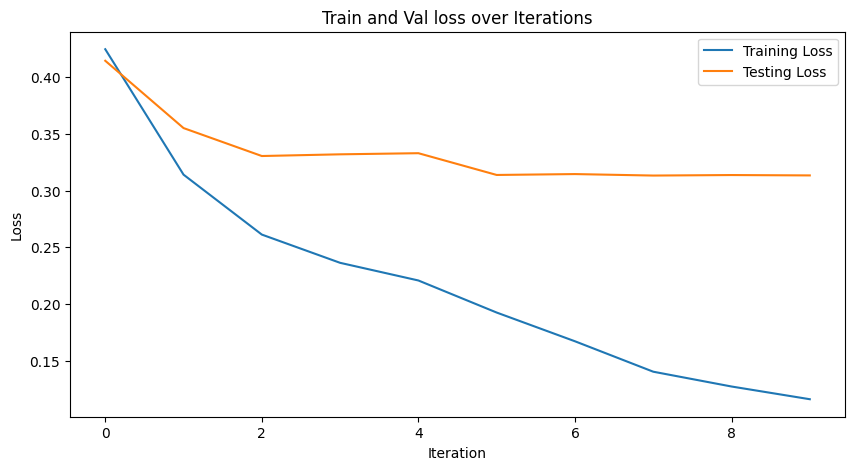

In [15]:
# Визуализации потерь
plt.figure(figsize=(10, 5))
plt.plot(results["train_loss"], label='Training Loss')
plt.plot(results["test_loss"], label='Testing Loss')
plt.title('Train and Val loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show() # По идее они быть, как паралельные прямые с небольшым разрывом и копировать патерны друг друга

# Гиперпараметры

# Новый раздел

In [ ]:
import itertools
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import torch
import csv

# Генерация всех возможных комбинаций цифр для width (например, до 3 элементов в списке)
def generate_width_configs(max_number=36, max_length=3):
    width_configs = []
    numbers = list(range(1, max_number + 1))
    for r in range(1, max_length + 1):
        for combo in itertools.permutations(numbers, r):
            width_configs.append(list(combo))
    return width_configs

# Define the ranges for each parameter
grid_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16, 17, 20, 25, 26, 27, 28, 29, 30] # Можно менять
k_values = [3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 20, 22] # Можно менять
width_configs = generate_width_configs(max_number=36, max_length=4) # не хочу рассматривать больше 4 скрытых слоёв, так как это может занять вечность и у нас не такой большой датасет

# Initialize variables to store the best results
best_r2 = -np.inf  # R² starts from a very low value
best_rmse = np.inf  # RMSE starts from a very high value
best_params = {}

# Список для хранения всех удачных конфигураций
successful_configs = []

# Счетчик для хранения групп конфигураций
config_group_counter = 0

# Perform grid search to find the best combination of parameters
for grid_val, k_val, width_config in itertools.product(grid_values, k_values, width_configs):
    # Создаем конфигурацию ширины сети
    width = [36] + width_config + [1]

    try:
        # Инициализируем модель с текущими параметрами
        model = KAN(width=width, grid=grid_val, k=k_val)

        # Train the model (assuming your model has a train method)
        results = model.fit({'train_input': train_input, 'train_label': train_label,
                             'test_input': test_input, 'test_label': test_label},
                            opt="LBFGS", steps=100, loss_fn=torch.nn.MSELoss()) # Количество шагов можно увеличить, но это сильно увеличит время поиска. И их не может быть меньше 10

        # Предсказание на тесте
        test_preds = model.forward(test_input).detach().numpy()

        # Evaluate the model on the test set
        r2 = r2_score(test_label.numpy(), test_preds)
        rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

        if r2 > 0.6:
            print(f"Configuration with R² > 0.7 found: R² = {r2}, RMSE = {rmse}, Grid = {grid_val}, k = {k_val}, Width = {width}")
        else:
            print(f"Configuration below threshold: R² = {r2}, Grid = {grid_val}, k = {k_val}, Width = {width}")

        # Maximize R² and minimize RMSE
        if r2 > best_r2 or (r2 == best_r2 and rmse < best_rmse):
            best_r2 = r2
            best_rmse = rmse
            best_params = {'grid': grid_val, 'k': k_val, 'width': width}

        # Сохранение конфигураций с R² > 0.7
        if r2 >= 0.7:
            successful_configs.append({
                'grid': grid_val,
                'k': k_val,
                'width': width,
                'r2': r2,
                'rmse': rmse
            })

           # Сохранение каждых 5 успешных конфигураций в отдельный файл
            if len(successful_configs) % 5 == 0:
                config_group_counter += 1
                filename = f'successful_configs_group_{config_group_counter}.csv'
                with open(filename, mode='w', newline='') as file:
                    writer = csv.DictWriter(file, fieldnames=['grid', 'k', 'width', 'r2', 'rmse'])
                    writer.writeheader()
                    for config in successful_configs[-5:]:
                        writer.writerow(config)

    # Бывает так, что конфигурация ломает все предсказания и её нужно пропустить, чтобы не получить ошибку
    except Exception as e:
        print(f"Skipping configuration grid={grid_val}, k={k_val}, width={width} due to error: {e}")
        continue  # Пропускаем текущую конфигурацию и продолжаем искать

# Сохранение всех успешных конфигураций в общий файл
if successful_configs:
    with open('successful_configs_full_list.csv', mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['grid', 'k', 'width', 'r2', 'rmse'])
        writer.writeheader()
        for config in successful_configs:
            writer.writerow(config)

print("Best parameters found:")
print(best_params)
print(f"Best R² on test set: {best_r2}")
print(f"Best RMSE on test set: {best_rmse}")

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.84e-01 | test_loss: 3.99e-01 | reg: 7.39e+01 | : 100%|█| 100/100 [00:42<00:00,  2.35


saving model version 0.1
Configuration below threshold: R² = 0.2964113843447377, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.33e-01 | test_loss: 4.25e-01 | reg: 4.38e+01 | : 100%|█| 100/100 [00:52<00:00,  1.91


saving model version 0.1
Configuration below threshold: R² = 0.20069176106342312, Grid = 2, k = 3, Width = [[36, 0], [2, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.96e-01 | test_loss: 3.70e-01 | reg: 8.55e+01 | : 100%|█| 100/100 [00:55<00:00,  1.81


saving model version 0.1
Configuration below threshold: R² = 0.3934910930248302, Grid = 2, k = 3, Width = [[36, 0], [3, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 4.28e-01 | reg: 1.20e+02 | : 100%|█| 100/100 [00:54<00:00,  1.83


saving model version 0.1
Configuration below threshold: R² = 0.1879092908262613, Grid = 2, k = 3, Width = [[36, 0], [4, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-01 | test_loss: 4.51e-01 | reg: 1.10e+02 | : 100%|█| 100/100 [00:55<00:00,  1.79


saving model version 0.1
Configuration below threshold: R² = 0.10071261052126945, Grid = 2, k = 3, Width = [[36, 0], [5, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.15e-01 | test_loss: 4.18e-01 | reg: 1.05e+02 | : 100%|█| 100/100 [00:57<00:00,  1.74


saving model version 0.1
Configuration below threshold: R² = 0.22560527371749062, Grid = 2, k = 3, Width = [[36, 0], [6, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.02e-01 | test_loss: 4.28e-01 | reg: 1.27e+02 | : 100%|█| 100/100 [01:04<00:00,  1.55


saving model version 0.1
Configuration below threshold: R² = 0.18895234872059086, Grid = 2, k = 3, Width = [[36, 0], [7, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.66e-02 | test_loss: 5.72e-01 | reg: 1.19e+02 | : 100%|█| 100/100 [01:03<00:00,  1.59


saving model version 0.1
Configuration below threshold: R² = -0.446421924228094, Grid = 2, k = 3, Width = [[36, 0], [8, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.34e-02 | test_loss: 6.23e-01 | reg: 1.35e+02 | : 100%|█| 100/100 [01:04<00:00,  1.55


saving model version 0.1
Configuration below threshold: R² = -0.7171030046712796, Grid = 2, k = 3, Width = [[36, 0], [9, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.04e-02 | test_loss: 6.03e-01 | reg: 1.59e+02 | : 100%|█| 100/100 [01:06<00:00,  1.51


saving model version 0.1
Configuration below threshold: R² = -0.6094099905989268, Grid = 2, k = 3, Width = [[36, 0], [10, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.36e-02 | test_loss: 5.41e-01 | reg: 1.33e+02 | : 100%|█| 100/100 [01:07<00:00,  1.48


saving model version 0.1
Configuration below threshold: R² = -0.296200239448392, Grid = 2, k = 3, Width = [[36, 0], [11, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.61e-02 | test_loss: 5.78e-01 | reg: 1.38e+02 | : 100%|█| 100/100 [01:10<00:00,  1.42


saving model version 0.1
Configuration below threshold: R² = -0.4810169647703719, Grid = 2, k = 3, Width = [[36, 0], [12, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.61e-02 | test_loss: 7.02e-01 | reg: 1.55e+02 | : 100%|█| 100/100 [01:15<00:00,  1.33


saving model version 0.1
Configuration below threshold: R² = -1.1805727204219485, Grid = 2, k = 3, Width = [[36, 0], [13, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.44e-02 | test_loss: 8.68e-01 | reg: 1.71e+02 | : 100%|█| 100/100 [01:17<00:00,  1.30


saving model version 0.1
Configuration below threshold: R² = -2.3347810561107174, Grid = 2, k = 3, Width = [[36, 0], [14, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.10e-02 | test_loss: 4.86e-01 | reg: 1.69e+02 | : 100%|█| 100/100 [01:20<00:00,  1.24


saving model version 0.1
Configuration below threshold: R² = -0.047244495493061756, Grid = 2, k = 3, Width = [[36, 0], [15, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.73e-02 | test_loss: 6.43e-01 | reg: 1.72e+02 | : 100%|█| 100/100 [01:22<00:00,  1.22


saving model version 0.1
Configuration below threshold: R² = -0.8308816416772913, Grid = 2, k = 3, Width = [[36, 0], [16, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.89e-02 | test_loss: 6.90e-01 | reg: 1.74e+02 | : 100%|█| 100/100 [01:22<00:00,  1.21


saving model version 0.1
Configuration below threshold: R² = -1.1070967841467625, Grid = 2, k = 3, Width = [[36, 0], [17, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.70e-02 | test_loss: 6.52e-01 | reg: 1.68e+02 | : 100%|█| 100/100 [01:24<00:00,  1.19


saving model version 0.1
Configuration below threshold: R² = -0.8817634006279806, Grid = 2, k = 3, Width = [[36, 0], [18, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.20e-02 | test_loss: 6.79e-01 | reg: 2.01e+02 | : 100%|█| 100/100 [01:27<00:00,  1.15


saving model version 0.1
Configuration below threshold: R² = -1.0386843376762624, Grid = 2, k = 3, Width = [[36, 0], [19, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.33e-02 | test_loss: 8.44e-01 | reg: 1.93e+02 | : 100%|█| 100/100 [01:29<00:00,  1.11


saving model version 0.1
Configuration below threshold: R² = -2.1546463015899757, Grid = 2, k = 3, Width = [[36, 0], [20, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.34e-02 | test_loss: 7.65e-01 | reg: 1.83e+02 | : 100%|█| 100/100 [01:32<00:00,  1.08


saving model version 0.1
Configuration below threshold: R² = -1.5938068528668463, Grid = 2, k = 3, Width = [[36, 0], [21, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.07e-02 | test_loss: 5.94e-01 | reg: 1.71e+02 | : 100%|█| 100/100 [01:35<00:00,  1.05


saving model version 0.1
Configuration below threshold: R² = -0.5597837956721958, Grid = 2, k = 3, Width = [[36, 0], [22, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.06e-02 | test_loss: 1.03e+00 | reg: 1.82e+02 | : 100%|█| 100/100 [01:40<00:00,  1.01


saving model version 0.1
Configuration below threshold: R² = -3.7292695238181937, Grid = 2, k = 3, Width = [[36, 0], [23, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.99e-02 | test_loss: 7.63e-01 | reg: 2.01e+02 | : 100%|█| 100/100 [01:45<00:00,  1.06


saving model version 0.1
Configuration below threshold: R² = -1.5759964653599008, Grid = 2, k = 3, Width = [[36, 0], [24, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.80e-02 | test_loss: 6.97e-01 | reg: 1.94e+02 | : 100%|█| 100/100 [01:51<00:00,  1.12


saving model version 0.1
Configuration below threshold: R² = -1.150447522013689, Grid = 2, k = 3, Width = [[36, 0], [25, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.01e-02 | test_loss: 6.44e-01 | reg: 2.03e+02 | : 100%|█| 100/100 [01:49<00:00,  1.10


saving model version 0.1
Configuration below threshold: R² = -0.8360720078488386, Grid = 2, k = 3, Width = [[36, 0], [26, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.76e-02 | test_loss: 5.54e-01 | reg: 2.22e+02 | : 100%|█| 100/100 [01:50<00:00,  1.10


saving model version 0.1
Configuration below threshold: R² = -0.3570649211268748, Grid = 2, k = 3, Width = [[36, 0], [27, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.12e-02 | test_loss: 7.46e-01 | reg: 2.15e+02 | : 100%|█| 100/100 [01:52<00:00,  1.12


saving model version 0.1
Configuration below threshold: R² = -1.4625750914168587, Grid = 2, k = 3, Width = [[36, 0], [28, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.08e-02 | test_loss: 9.10e-01 | reg: 2.10e+02 | : 100%|█| 100/100 [01:55<00:00,  1.16


saving model version 0.1
Configuration below threshold: R² = -2.6648312397112512, Grid = 2, k = 3, Width = [[36, 0], [29, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.20e-02 | test_loss: 5.58e-01 | reg: 2.23e+02 | : 100%|█| 100/100 [02:00<00:00,  1.20


saving model version 0.1
Configuration below threshold: R² = -0.3806938507195885, Grid = 2, k = 3, Width = [[36, 0], [30, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.65e-02 | test_loss: 6.62e-01 | reg: 2.16e+02 | : 100%|█| 100/100 [02:02<00:00,  1.22


saving model version 0.1
Configuration below threshold: R² = -0.9423328358735816, Grid = 2, k = 3, Width = [[36, 0], [31, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.70e-02 | test_loss: 7.77e-01 | reg: 2.23e+02 | : 100%|█| 100/100 [01:58<00:00,  1.18


saving model version 0.1
Configuration below threshold: R² = -1.6697701887713912, Grid = 2, k = 3, Width = [[36, 0], [32, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.75e-02 | test_loss: 6.84e-01 | reg: 2.39e+02 | : 100%|█| 100/100 [02:09<00:00,  1.30


saving model version 0.1
Configuration below threshold: R² = -1.069791585945854, Grid = 2, k = 3, Width = [[36, 0], [33, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.59e-02 | test_loss: 7.56e-01 | reg: 2.16e+02 | : 100%|█| 100/100 [02:08<00:00,  1.28


saving model version 0.1
Configuration below threshold: R² = -1.533074033216915, Grid = 2, k = 3, Width = [[36, 0], [34, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.90e-02 | test_loss: 6.70e-01 | reg: 2.24e+02 | : 100%|█| 100/100 [02:12<00:00,  1.32


saving model version 0.1
Configuration below threshold: R² = -0.9849496913473312, Grid = 2, k = 3, Width = [[36, 0], [35, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.90e-02 | test_loss: 9.10e-01 | reg: 2.19e+02 | : 100%|█| 100/100 [02:15<00:00,  1.36


saving model version 0.1
Configuration below threshold: R² = -2.6648117695409175, Grid = 2, k = 3, Width = [[36, 0], [36, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.14e-01 | test_loss: 5.62e-01 | reg: 5.30e+01 | : 100%|█| 100/100 [00:55<00:00,  1.81


saving model version 0.1
Configuration below threshold: R² = -0.3992052566147317, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [2, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.79e-01 | test_loss: 4.14e-01 | reg: 3.65e+01 | : 100%|█| 100/100 [00:56<00:00,  1.77


saving model version 0.1
Configuration below threshold: R² = 0.23998412762372334, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [3, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.83e-01 | test_loss: 3.98e-01 | reg: 4.09e+01 | : 100%|█| 100/100 [00:59<00:00,  1.69


saving model version 0.1
Configuration below threshold: R² = 0.29884636338066284, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [4, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.71e-01 | test_loss: 3.92e-01 | reg: 3.82e+01 | : 100%|█| 100/100 [00:59<00:00,  1.69


saving model version 0.1
Configuration below threshold: R² = 0.3184204754960497, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [5, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.79e-01 | test_loss: 3.96e-01 | reg: 6.01e+01 | : 100%|█| 100/100 [01:02<00:00,  1.61


saving model version 0.1
Configuration below threshold: R² = 0.3041972533610957, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [6, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.95e-01 | test_loss: 5.00e-01 | reg: 5.43e+01 | : 100%|█| 100/100 [01:04<00:00,  1.56


saving model version 0.1
Configuration below threshold: R² = -0.1062973802988656, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [7, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.81e-01 | test_loss: 4.06e-01 | reg: 5.69e+01 | : 100%|█| 100/100 [01:04<00:00,  1.54


saving model version 0.1
Configuration below threshold: R² = 0.2714946013541697, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [8, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.86e-01 | test_loss: 1.06e+00 | reg: 4.35e+01 | : 100%|█| 100/100 [01:10<00:00,  1.42


saving model version 0.1
Configuration below threshold: R² = -4.012971642145906, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [9, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.19e-01 | test_loss: 4.38e-01 | reg: 9.75e+01 | : 100%|█| 100/100 [01:10<00:00,  1.42


saving model version 0.1
Configuration below threshold: R² = 0.15050134966688822, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [10, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.76e-01 | test_loss: 4.17e-01 | reg: 5.07e+01 | : 100%|█| 100/100 [01:10<00:00,  1.42


saving model version 0.1
Configuration below threshold: R² = 0.23032777595931342, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [11, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.29e-01 | test_loss: 4.77e-01 | reg: 1.99e+02 | : 100%|█| 100/100 [00:59<00:00,  1.67


saving model version 0.1
Configuration below threshold: R² = -0.0064513302839823705, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [12, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.00e-01 | test_loss: 4.00e-01 | reg: 6.23e+01 | : 100%|█| 100/100 [01:12<00:00,  1.38


saving model version 0.1
Configuration below threshold: R² = 0.292792858208489, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [13, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.74e-01 | test_loss: 3.87e-01 | reg: 4.32e+01 | : 100%|█| 100/100 [01:16<00:00,  1.30


saving model version 0.1
Configuration below threshold: R² = 0.3368623855566262, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [14, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.98e-01 | test_loss: 3.57e-01 | reg: 7.31e+01 | : 100%|█| 100/100 [00:51<00:00,  1.95


saving model version 0.1
Configuration below threshold: R² = 0.4351179367164292, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [15, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.77e-01 | test_loss: 3.94e-01 | reg: 6.03e+01 | : 100%|█| 100/100 [01:16<00:00,  1.31


saving model version 0.1
Configuration below threshold: R² = 0.3143074043115339, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [16, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.28e-01 | test_loss: 2.39e+00 | reg: 9.18e+01 | : 100%|█| 100/100 [01:16<00:00,  1.30


saving model version 0.1
Configuration below threshold: R² = -24.31782523534242, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [17, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.01e-01 | test_loss: 3.91e-01 | reg: 9.22e+01 | : 100%|█| 100/100 [01:25<00:00,  1.17


saving model version 0.1
Configuration below threshold: R² = 0.3239127113444701, Grid = 2, k = 3, Width = [[36, 0], [1, 0], [18, 0], [1, 0]]
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.00e-01 | test_loss: 4.06e-01 | reg: 0.00e+00 | :  79%|▊| 79/100 [01:02<00:15,  1.37i

# Старые версии подбора гиперпараметров

## пример подбора k и grid для задачи классификации, то есть на выходе в KAN(width=[166,1,2] там 2, то есть предсказывается вхождение в 2 класса, а не как у меня 1 в конце. У меня задача регрессии, я предсказываю эти значения в коцне

```
import itertools

# Define the ranges for each parameter
grid_values = [1, 5, 10, 20, 30]
k_values = [3, 5, 7]

best_accuracy = 0
best_params = {}

# Perform grid search to find the best combination of parameters
for grid_val, k_val in itertools.product(grid_values, k_values):
    model = KAN(width=[166,1,2], grid=grid_val, k=k_val)
    results = model.train(dataset, opt="LBFGS", steps=10, metrics=(train_acc, test_acc))

    train_accuracy = results['train_acc'][-1]
    test_accuracy = results['test_acc'][-1]

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_params = {'grid': grid_val, 'k': k_val}

print("Best parameters found:")
print(best_params)
print("Best test accuracy:", best_accuracy)
```



In [ ]:
'''
Старая версия
import itertools
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import torch

# Генерация всех возможных комбинаций цифр для width (например, до 3 элементов в списке)
def generate_width_configs(max_number=36, max_length=3):
    width_configs = []
    numbers = list(range(1, max_number + 1))
    for r in range(1, max_length + 1):
        for combo in itertools.permutations(numbers, r):
            width_configs.append(list(combo))
    return width_configs

# Define the ranges for each parameter
grid_values = [2, 3, 4, 5, 6, 7, 8, 9, 10,  15, 16, 17, 20, 25, 26, 27, 28, 29, 30] # Можно менять
k_values = [3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 20, 22] # Можно менять
width_configs = generate_width_configs(max_number=36, max_length=4) # не хочу расссматривать больше 4 скрытых слоёв, так как это может занять вечность и у нас не такой большой датасет

# Initialize variables to store the best results
best_r2 = -np.inf  # R² starts from a very low value
best_rmse = np.inf  # RMSE starts from a very high value
best_params = {}

# Список для хранения удачных конфигураций
successful_configs = []

# Perform grid search to find the best combination of parameters
for grid_val, k_val, width_config in itertools.product(grid_values, k_values, width_configs):
    # Создаем конфигурацию ширины сети
    width = [36] + width_config + [1]

    try:
        # Инициализируем модель с текущими параметрами
        model = KAN(width=width, grid=grid_val, k=k_val)

        # Train the model (assuming your model has a train method)
        results = model.fit({'train_input': train_input, 'train_label': train_label,
                             'test_input': test_input, 'test_label': test_label},
                            opt="LBFGS", steps=10, loss_fn=torch.nn.MSELoss()) # Количество шагов можно увеличить, но это сильно увеличит время поиска

        # Предсказание на тесте
        test_preds = model.forward(test_input).detach().numpy()

        # Evaluate the model on the test set
        r2 = r2_score(test_label.numpy(), test_preds)
        rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

        # Print metrics and configuration if R² is above 0.6
        if r2 > 0.6:
            print(f"Configuration with R² > 0.6 found: R² = {r2}, RMSE = {rmse}, Grid = {grid_val}, k = {k_val}, Width = {width}")

        # Maximize R² and minimize RMSE
        if r2 > best_r2 or (r2 == best_r2 and rmse < best_rmse):
            best_r2 = r2
            best_rmse = rmse
            best_params = {'grid': grid_val, 'k': k_val, 'width': width}

        # Сохранение конфигураций с R² > 0.6
        if r2 > 0.6:
            successful_configs.append({
                'grid': grid_val,
                'k': k_val,
                'width': width,
                'r2': r2,
                'rmse': rmse
            })

    # Бывает так, что конфигурация ломает все предсказания и её нужно пропустить, чтобы не получить ошибку
    except Exception as e:
        print(f"Skipping configuration grid={grid_val}, k={k_val}, width={width} due to error: {e}")
        continue  # Пропускаем текущую конфигурацию и продолжаем искать

# Выгрузка успешных конфигураций в CSV файл
with open('successful_configs.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=['grid', 'k', 'width', 'r2', 'rmse'])
    writer.writeheader()
    for config in successful_configs:
        writer.writerow(config)

print("Best parameters found:")
print(best_params)
print(f"Best R² on test set: {best_r2}")
print(f"Best RMSE on test set: {best_rmse}")
'''

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.37e-01 | test_loss: 4.11e-01 | reg: 4.17e+01 | : 100%|█| 10/10 [00:03<00:00,  2.59it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.11e-01 | test_loss: 3.87e-01 | reg: 2.10e+01 | : 100%|█| 10/10 [00:05<00:00,  1.76it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.84e-01 | test_loss: 4.17e-01 | reg: 5.49e+01 | : 100%|█| 10/10 [00:04<00:00,  2.16it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.72e-01 | test_loss: 3.99e-01 | reg: 7.14e+01 | : 100%|█| 10/10 [00:05<00:00,  1.72it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.32e-01 | test_loss: 3.74e-01 | reg: 6.27e+01 | : 100%|█| 10/10 [00:05<00:00,  1.98it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.13e-01 | test_loss: 3.34e-01 | reg: 5.93e+01 | : 100%|█| 10/10 [00:05<00:00,  1.84it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.21e-01 | test_loss: 3.25e-01 | reg: 6.58e+01 | : 100%|█| 10/10 [00:07<00:00,  1.41it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.05e-01 | test_loss: 3.63e-01 | reg: 6.14e+01 | : 100%|█| 10/10 [00:05<00:00,  1.71it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.11e-01 | test_loss: 3.40e-01 | reg: 7.91e+01 | : 100%|█| 10/10 [00:07<00:00,  1.37it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.09e-01 | test_loss: 3.52e-01 | reg: 8.07e+01 | : 100%|█| 10/10 [00:06<00:00,  1.59it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.87e-01 | test_loss: 3.95e-01 | reg: 7.51e+01 | : 100%|█| 10/10 [00:07<00:00,  1.34it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 3.27e-01 | reg: 8.13e+01 | : 100%|█| 10/10 [00:07<00:00,  1.38it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.99e-01 | test_loss: 3.51e-01 | reg: 8.43e+01 | : 100%|█| 10/10 [00:07<00:00,  1.33it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.80e-01 | test_loss: 3.40e-01 | reg: 9.21e+01 | : 100%|█| 10/10 [00:08<00:00,  1.21it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.90e-01 | test_loss: 3.14e-01 | reg: 9.08e+01 | : 100%|█| 10/10 [00:07<00:00,  1.35it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.30e-01 | reg: 9.78e+01 | : 100%|█| 10/10 [00:08<00:00,  1.21it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.76e-01 | test_loss: 3.12e-01 | reg: 9.90e+01 | : 100%|█| 10/10 [00:08<00:00,  1.12it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.76e-01 | test_loss: 3.26e-01 | reg: 9.73e+01 | : 100%|█| 10/10 [00:10<00:00,  1.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.76e-01 | test_loss: 3.71e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.35e-01 | reg: 1.19e+02 | : 100%|█| 10/10 [00:09<00:00,  1.09it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.68e-01 | test_loss: 3.81e-01 | reg: 1.16e+02 | : 100%|█| 10/10 [00:09<00:00,  1.11it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 3.19e-01 | reg: 1.05e+02 | : 100%|█| 10/10 [00:10<00:00,  1.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 3.66e-01 | reg: 1.11e+02 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 3.85e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.69e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:11<00:00,  1.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 3.47e-01 | reg: 1.26e+02 | : 100%|█| 10/10 [00:10<00:00,  1.07s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.52e-01 | reg: 1.28e+02 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.68e-01 | test_loss: 3.59e-01 | reg: 1.30e+02 | : 100%|█| 10/10 [00:12<00:00,  1.20s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 3.26e-01 | reg: 1.26e+02 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.76e-01 | test_loss: 3.16e-01 | reg: 1.28e+02 | : 100%|█| 10/10 [00:12<00:00,  1.27s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 3.62e-01 | reg: 1.36e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 3.23e-01 | reg: 1.36e+02 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 3.26e-01 | reg: 1.50e+02 | : 100%|█| 10/10 [00:13<00:00,  1.34s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.26e-01 | reg: 1.33e+02 | : 100%|█| 10/10 [00:13<00:00,  1.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 3.27e-01 | reg: 1.39e+02 | : 100%|█| 10/10 [00:14<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 3.25e-01 | reg: 1.42e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.46e-01 | test_loss: 3.97e-01 | reg: 4.41e+01 | : 100%|█| 10/10 [00:06<00:00,  1.58it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.44e-01 | test_loss: 3.89e-01 | reg: 2.25e+01 | : 100%|█| 10/10 [00:05<00:00,  1.89it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.28e-01 | test_loss: 3.91e-01 | reg: 2.80e+01 | : 100%|█| 10/10 [00:06<00:00,  1.50it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.18e-01 | test_loss: 4.00e-01 | reg: 2.84e+01 | : 100%|█| 10/10 [00:05<00:00,  1.80it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e-01 | test_loss: 3.89e-01 | reg: 2.79e+01 | : 100%|█| 10/10 [00:06<00:00,  1.50it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e-01 | test_loss: 3.97e-01 | reg: 2.90e+01 | : 100%|█| 10/10 [00:05<00:00,  1.75it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e-01 | test_loss: 3.79e-01 | reg: 3.41e+01 | : 100%|█| 10/10 [00:06<00:00,  1.61it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.34e-01 | test_loss: 3.84e-01 | reg: 3.45e+01 | : 100%|█| 10/10 [00:07<00:00,  1.27it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.57e-01 | test_loss: 4.00e-01 | reg: 5.81e+01 | : 100%|█| 10/10 [00:07<00:00,  1.37it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.26e-01 | test_loss: 3.97e-01 | reg: 3.54e+01 | : 100%|█| 10/10 [00:06<00:00,  1.65it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.42e-01 | test_loss: 4.51e-01 | reg: 4.20e+01 | : 100%|█| 10/10 [00:07<00:00,  1.34it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.39e-01 | test_loss: 3.92e-01 | reg: 3.96e+01 | : 100%|█| 10/10 [00:06<00:00,  1.59it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e-01 | test_loss: 3.84e-01 | reg: 3.27e+01 | : 100%|█| 10/10 [00:07<00:00,  1.27it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.30e-01 | test_loss: 3.77e-01 | reg: 3.37e+01 | : 100%|█| 10/10 [00:06<00:00,  1.52it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.23e-01 | test_loss: 4.10e-01 | reg: 4.26e+01 | : 100%|█| 10/10 [00:07<00:00,  1.29it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.74e-01 | test_loss: 4.29e-01 | reg: 4.29e+01 | : 100%|█| 10/10 [00:07<00:00,  1.40it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.53e-01 | test_loss: 4.06e-01 | reg: 4.27e+01 | : 100%|█| 10/10 [00:08<00:00,  1.17it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e-01 | test_loss: 3.86e-01 | reg: 4.03e+01 | : 100%|█| 10/10 [00:07<00:00,  1.34it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.15e-01 | test_loss: 3.82e-01 | reg: 4.16e+01 | : 100%|█| 10/10 [00:08<00:00,  1.19it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.39e-01 | test_loss: 3.96e-01 | reg: 3.85e+01 | : 100%|█| 10/10 [00:08<00:00,  1.16it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e-01 | test_loss: 6.90e-01 | reg: 4.59e+01 | : 100%|█| 10/10 [00:07<00:00,  1.33it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.14e-01 | test_loss: 3.98e-01 | reg: 4.23e+01 | : 100%|█| 10/10 [00:09<00:00,  1.09it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.29e-01 | test_loss: 3.89e-01 | reg: 4.26e+01 | : 100%|█| 10/10 [00:08<00:00,  1.12it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.36e-01 | test_loss: 3.85e-01 | reg: 4.15e+01 | : 100%|█| 10/10 [00:08<00:00,  1.22it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.25e-01 | test_loss: 3.94e-01 | reg: 4.33e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.29e-01 | test_loss: 3.92e-01 | reg: 4.26e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.36e-01 | test_loss: 4.13e-01 | reg: 4.33e+01 | : 100%|█| 10/10 [00:09<00:00,  1.10it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.45e-01 | test_loss: 3.93e-01 | reg: 4.45e+01 | : 100%|█| 10/10 [00:10<00:00,  1.00s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.54e-01 | test_loss: 4.14e-01 | reg: 4.38e+01 | : 100%|█| 10/10 [00:10<00:00,  1.03s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.40e-01 | test_loss: 4.00e-01 | reg: 4.99e+01 | : 100%|█| 10/10 [00:10<00:00,  1.02s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.63e-01 | test_loss: 4.65e-01 | reg: 4.77e+01 | : 100%|█| 10/10 [00:09<00:00,  1.09it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.52e-01 | test_loss: 4.11e-01 | reg: 4.61e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.48e-01 | test_loss: 4.66e-01 | reg: 4.80e+01 | : 100%|█| 10/10 [00:12<00:00,  1.20s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e-01 | test_loss: 4.10e-01 | reg: 5.03e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.25e-01 | test_loss: 3.97e-01 | reg: 5.18e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.89e-01 | test_loss: 3.71e-01 | reg: 2.20e+01 | : 100%|█| 10/10 [00:05<00:00,  1.93it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.07e-01 | test_loss: 3.86e-01 | reg: 2.51e+01 | : 100%|█| 10/10 [00:07<00:00,  1.42it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.75e-01 | test_loss: 3.57e-01 | reg: 3.02e+01 | : 100%|█| 10/10 [00:05<00:00,  1.67it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.90e-01 | test_loss: 3.76e-01 | reg: 3.56e+01 | : 100%|█| 10/10 [00:07<00:00,  1.40it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.69e-01 | test_loss: 4.57e-01 | reg: 3.54e+01 | : 100%|█| 10/10 [00:06<00:00,  1.62it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.68e-01 | test_loss: 4.36e-01 | reg: 4.02e+01 | : 100%|█| 10/10 [00:07<00:00,  1.30it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.86e-01 | test_loss: 3.64e-01 | reg: 3.19e+01 | : 100%|█| 10/10 [00:06<00:00,  1.52it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.83e-01 | test_loss: 3.63e-01 | reg: 4.01e+01 | : 100%|█| 10/10 [00:07<00:00,  1.26it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.51e-01 | test_loss: 3.81e-01 | reg: 4.14e+01 | : 100%|█| 10/10 [00:06<00:00,  1.46it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.79e-01 | test_loss: 3.71e-01 | reg: 4.69e+01 | : 100%|█| 10/10 [00:08<00:00,  1.23it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.54e-01 | test_loss: 3.70e-01 | reg: 4.37e+01 | : 100%|█| 10/10 [00:07<00:00,  1.34it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.96e-01 | test_loss: 3.72e-01 | reg: 4.43e+01 | : 100%|█| 10/10 [00:08<00:00,  1.14it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.85e-01 | test_loss: 3.74e-01 | reg: 6.09e+01 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.49e-01 | test_loss: 3.59e-01 | reg: 4.77e+01 | : 100%|█| 10/10 [00:09<00:00,  1.04it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.69e-01 | test_loss: 4.28e-01 | reg: 5.02e+01 | : 100%|█| 10/10 [00:08<00:00,  1.22it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.67e-01 | test_loss: 3.62e-01 | reg: 4.79e+01 | : 100%|█| 10/10 [00:08<00:00,  1.13it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.69e-01 | test_loss: 3.44e-01 | reg: 4.76e+01 | : 100%|█| 10/10 [00:07<00:00,  1.29it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.82e-01 | test_loss: 3.71e-01 | reg: 5.01e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.58e-01 | test_loss: 3.45e-01 | reg: 4.91e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.72e-01 | test_loss: 3.90e-01 | reg: 5.45e+01 | : 100%|█| 10/10 [00:08<00:00,  1.21it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.03e-01 | test_loss: 3.69e-01 | reg: 5.20e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.87e-01 | test_loss: 3.61e-01 | reg: 5.26e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.50e-01 | test_loss: 3.58e-01 | reg: 5.35e+01 | : 100%|█| 10/10 [00:08<00:00,  1.13it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.62e-01 | test_loss: 3.80e-01 | reg: 5.43e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.55e-01 | test_loss: 3.77e-01 | reg: 5.50e+01 | : 100%|█| 10/10 [00:10<00:00,  1.02s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.64e-01 | test_loss: 3.61e-01 | reg: 5.31e+01 | : 100%|█| 10/10 [00:10<00:00,  1.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.70e-01 | test_loss: 3.71e-01 | reg: 5.09e+01 | : 100%|█| 10/10 [00:09<00:00,  1.05it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.70e-01 | test_loss: 3.94e-01 | reg: 6.09e+01 | : 100%|█| 10/10 [00:10<00:00,  1.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.60e-01 | test_loss: 3.58e-01 | reg: 5.46e+01 | : 100%|█| 10/10 [00:10<00:00,  1.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.62e-01 | test_loss: 3.50e-01 | reg: 6.01e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.50e-01 | test_loss: 3.81e-01 | reg: 6.04e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.49e-01 | test_loss: 3.57e-01 | reg: 5.92e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.60e-01 | test_loss: 4.04e-01 | reg: 5.55e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.62e-01 | test_loss: 3.71e-01 | reg: 6.33e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.48e-01 | test_loss: 3.61e-01 | reg: 5.77e+01 | : 100%|█| 10/10 [00:11<00:00,  1.17s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.04e-01 | test_loss: 3.88e-01 | reg: 7.88e+01 | : 100%|█| 10/10 [00:05<00:00,  1.70it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.03e-01 | test_loss: 3.74e-01 | reg: 5.60e+01 | : 100%|█| 10/10 [00:07<00:00,  1.39it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.82e-01 | test_loss: 3.88e-01 | reg: 4.40e+01 | : 100%|█| 10/10 [00:06<00:00,  1.60it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.50e-01 | test_loss: 3.65e-01 | reg: 4.10e+01 | : 100%|█| 10/10 [00:07<00:00,  1.33it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.38e-01 | test_loss: 3.38e-01 | reg: 4.15e+01 | : 100%|█| 10/10 [00:06<00:00,  1.50it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.41e-01 | test_loss: 3.45e-01 | reg: 4.16e+01 | : 100%|█| 10/10 [00:07<00:00,  1.33it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.71e-01 | test_loss: 4.02e-01 | reg: 3.81e+01 | : 100%|█| 10/10 [00:07<00:00,  1.29it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.24e-01 | test_loss: 3.57e-01 | reg: 4.92e+01 | : 100%|█| 10/10 [00:07<00:00,  1.40it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.32e-01 | test_loss: 3.40e-01 | reg: 5.13e+01 | : 100%|█| 10/10 [00:08<00:00,  1.24it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.40e-01 | test_loss: 3.42e-01 | reg: 4.66e+01 | : 100%|█| 10/10 [00:06<00:00,  1.43it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.45e-01 | test_loss: 3.98e-01 | reg: 5.31e+01 | : 100%|█| 10/10 [00:08<00:00,  1.21it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.25e-01 | test_loss: 3.76e-01 | reg: 5.53e+01 | : 100%|█| 10/10 [00:07<00:00,  1.31it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.32e-01 | test_loss: 3.47e-01 | reg: 5.06e+01 | : 100%|█| 10/10 [00:09<00:00,  1.06it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.29e-01 | test_loss: 3.45e-01 | reg: 4.82e+01 | : 100%|█| 10/10 [00:08<00:00,  1.14it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.34e-01 | test_loss: 3.31e-01 | reg: 5.89e+01 | : 100%|█| 10/10 [00:07<00:00,  1.31it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.34e-01 | test_loss: 3.57e-01 | reg: 5.62e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.16e-01 | test_loss: 3.41e-01 | reg: 6.00e+01 | : 100%|█| 10/10 [00:09<00:00,  1.10it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.21e-01 | test_loss: 3.25e-01 | reg: 5.84e+01 | : 100%|█| 10/10 [00:08<00:00,  1.21it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.35e-01 | test_loss: 3.31e-01 | reg: 6.13e+01 | : 100%|█| 10/10 [00:09<00:00,  1.06it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.24e-01 | test_loss: 3.26e-01 | reg: 5.77e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.16e-01 | test_loss: 3.56e-01 | reg: 6.53e+01 | : 100%|█| 10/10 [00:08<00:00,  1.14it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.22e-01 | test_loss: 3.64e-01 | reg: 6.09e+01 | : 100%|█| 10/10 [00:09<00:00,  1.02it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.23e-01 | test_loss: 3.77e-01 | reg: 6.12e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.37e-01 | test_loss: 3.63e-01 | reg: 6.25e+01 | : 100%|█| 10/10 [00:10<00:00,  1.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.37e-01 | test_loss: 3.84e-01 | reg: 6.01e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.16e-01 | test_loss: 3.41e-01 | reg: 6.47e+01 | : 100%|█| 10/10 [00:10<00:00,  1.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.33e-01 | test_loss: 3.47e-01 | reg: 6.91e+01 | : 100%|█| 10/10 [00:10<00:00,  1.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.20e-01 | test_loss: 4.26e-01 | reg: 6.40e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.20e-01 | test_loss: 3.59e-01 | reg: 6.87e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.45e-01 | test_loss: 3.75e-01 | reg: 6.37e+01 | : 100%|█| 10/10 [00:10<00:00,  1.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.25e-01 | test_loss: 3.62e-01 | reg: 6.51e+01 | : 100%|█| 10/10 [00:10<00:00,  1.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.35e-01 | test_loss: 3.62e-01 | reg: 7.45e+01 | : 100%|█| 10/10 [00:11<00:00,  1.17s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.20e-01 | test_loss: 3.19e-01 | reg: 6.83e+01 | : 100%|█| 10/10 [00:11<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.23e-01 | test_loss: 3.53e-01 | reg: 6.44e+01 | : 100%|█| 10/10 [00:12<00:00,  1.20s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.22e-01 | test_loss: 3.24e-01 | reg: 7.08e+01 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.77e-01 | test_loss: 3.83e-01 | reg: 5.82e+01 | : 100%|█| 10/10 [00:05<00:00,  1.73it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.50e-01 | test_loss: 3.43e-01 | reg: 5.12e+01 | : 100%|█| 10/10 [00:07<00:00,  1.39it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.33e-01 | test_loss: 3.37e-01 | reg: 4.08e+01 | : 100%|█| 10/10 [00:06<00:00,  1.65it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.19e-01 | test_loss: 3.46e-01 | reg: 4.20e+01 | : 100%|█| 10/10 [00:07<00:00,  1.32it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.99e-01 | test_loss: 3.22e-01 | reg: 4.22e+01 | : 100%|█| 10/10 [00:06<00:00,  1.52it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.10e-01 | test_loss: 3.47e-01 | reg: 4.62e+01 | : 100%|█| 10/10 [00:08<00:00,  1.25it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.26e-01 | test_loss: 3.34e-01 | reg: 4.55e+01 | : 100%|█| 10/10 [00:07<00:00,  1.35it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.22e-01 | test_loss: 3.17e-01 | reg: 5.16e+01 | : 100%|█| 10/10 [00:07<00:00,  1.35it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.08e-01 | test_loss: 3.40e-01 | reg: 5.07e+01 | : 100%|█| 10/10 [00:08<00:00,  1.23it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.22e-01 | test_loss: 3.56e-01 | reg: 5.56e+01 | : 100%|█| 10/10 [00:07<00:00,  1.40it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.20e-01 | test_loss: 3.55e-01 | reg: 5.45e+01 | : 100%|█| 10/10 [00:08<00:00,  1.15it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.90e-01 | test_loss: 2.96e-01 | reg: 5.57e+01 | : 100%|█| 10/10 [00:07<00:00,  1.37it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.19e-01 | test_loss: 3.43e-01 | reg: 5.68e+01 | : 100%|█| 10/10 [00:08<00:00,  1.12it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.15e-01 | test_loss: 3.50e-01 | reg: 5.75e+01 | : 100%|█| 10/10 [00:08<00:00,  1.12it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.96e-01 | test_loss: 3.43e-01 | reg: 5.82e+01 | : 100%|█| 10/10 [00:07<00:00,  1.30it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.98e-01 | test_loss: 3.30e-01 | reg: 6.13e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.04e-01 | test_loss: 3.53e-01 | reg: 6.47e+01 | : 100%|█| 10/10 [00:09<00:00,  1.09it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.06e-01 | test_loss: 3.47e-01 | reg: 6.46e+01 | : 100%|█| 10/10 [00:08<00:00,  1.22it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.91e-01 | test_loss: 3.98e-01 | reg: 6.43e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.90e-01 | test_loss: 3.57e-01 | reg: 6.68e+01 | : 100%|█| 10/10 [00:10<00:00,  1.02s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.00e-01 | test_loss: 3.29e-01 | reg: 6.68e+01 | : 100%|█| 10/10 [00:08<00:00,  1.16it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.16e-01 | test_loss: 3.36e-01 | reg: 6.67e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.97e-01 | test_loss: 3.32e-01 | reg: 7.28e+01 | : 100%|█| 10/10 [00:10<00:00,  1.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.86e-01 | test_loss: 3.63e-01 | reg: 6.94e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.99e-01 | test_loss: 3.23e-01 | reg: 6.47e+01 | : 100%|█| 10/10 [00:10<00:00,  1.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.15e-01 | test_loss: 3.41e-01 | reg: 6.90e+01 | : 100%|█| 10/10 [00:10<00:00,  1.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.15e-01 | test_loss: 3.49e-01 | reg: 6.99e+01 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.12e-01 | test_loss: 4.04e-01 | reg: 7.24e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.08e-01 | test_loss: 3.16e-01 | reg: 7.38e+01 | : 100%|█| 10/10 [00:11<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.03e-01 | test_loss: 3.45e-01 | reg: 7.45e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.93e-01 | test_loss: 3.60e-01 | reg: 6.89e+01 | : 100%|█| 10/10 [00:10<00:00,  1.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.07e-01 | test_loss: 4.42e-01 | reg: 6.84e+01 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.05e-01 | test_loss: 3.54e-01 | reg: 7.79e+01 | : 100%|█| 10/10 [00:11<00:00,  1.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.03e-01 | test_loss: 3.56e-01 | reg: 7.87e+01 | : 100%|█| 10/10 [00:11<00:00,  1.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.93e-01 | test_loss: 3.26e-01 | reg: 7.26e+01 | : 100%|█| 10/10 [00:12<00:00,  1.22s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.29e-01 | test_loss: 3.65e-01 | reg: 3.19e+01 | : 100%|█| 10/10 [00:05<00:00,  1.71it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.37e-01 | test_loss: 3.39e-01 | reg: 3.86e+01 | : 100%|█| 10/10 [00:07<00:00,  1.31it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.47e-01 | test_loss: 3.39e-01 | reg: 3.74e+01 | : 100%|█| 10/10 [00:06<00:00,  1.50it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.13e-01 | test_loss: 3.46e-01 | reg: 4.21e+01 | : 100%|█| 10/10 [00:07<00:00,  1.33it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.06e-01 | test_loss: 3.42e-01 | reg: 4.23e+01 | : 100%|█| 10/10 [00:07<00:00,  1.35it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.13e-01 | test_loss: 3.72e-01 | reg: 4.94e+01 | : 100%|█| 10/10 [00:07<00:00,  1.32it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.10e-01 | test_loss: 3.48e-01 | reg: 4.76e+01 | : 100%|█| 10/10 [00:08<00:00,  1.21it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.03e-01 | test_loss: 3.42e-01 | reg: 5.40e+01 | : 100%|█| 10/10 [00:07<00:00,  1.40it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.25e-01 | test_loss: 3.27e-01 | reg: 5.07e+01 | : 100%|█| 10/10 [00:08<00:00,  1.16it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.99e-01 | test_loss: 6.17e-01 | reg: 5.93e+01 | : 100%|█| 10/10 [00:07<00:00,  1.30it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.97e-01 | test_loss: 3.64e-01 | reg: 5.65e+01 | : 100%|█| 10/10 [00:08<00:00,  1.16it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.91e-01 | test_loss: 3.33e-01 | reg: 6.18e+01 | : 100%|█| 10/10 [00:09<00:00,  1.11it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.03e-01 | test_loss: 3.64e-01 | reg: 5.60e+01 | : 100%|█| 10/10 [00:07<00:00,  1.26it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.95e-01 | test_loss: 3.19e-01 | reg: 6.36e+01 | : 100%|█| 10/10 [00:10<00:00,  1.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.76e-01 | test_loss: 3.49e-01 | reg: 6.84e+01 | : 100%|█| 10/10 [00:09<00:00,  1.06it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.88e-01 | test_loss: 4.34e-01 | reg: 6.78e+01 | : 100%|█| 10/10 [00:08<00:00,  1.19it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.84e-01 | test_loss: 3.64e-01 | reg: 7.10e+01 | : 100%|█| 10/10 [00:09<00:00,  1.05it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.92e-01 | test_loss: 4.56e-01 | reg: 6.76e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.96e-01 | test_loss: 3.29e-01 | reg: 6.62e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.91e-01 | test_loss: 3.54e-01 | reg: 7.03e+01 | : 100%|█| 10/10 [00:09<00:00,  1.09it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.92e-01 | test_loss: 3.56e-01 | reg: 7.71e+01 | : 100%|█| 10/10 [00:10<00:00,  1.03s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.93e-01 | test_loss: 3.81e-01 | reg: 7.46e+01 | : 100%|█| 10/10 [00:10<00:00,  1.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.81e-01 | test_loss: 3.17e-01 | reg: 7.66e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.82e-01 | test_loss: 3.44e-01 | reg: 7.48e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.86e-01 | test_loss: 3.32e-01 | reg: 8.07e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.84e-01 | test_loss: 3.45e-01 | reg: 8.10e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.94e-01 | test_loss: 3.27e-01 | reg: 7.70e+01 | : 100%|█| 10/10 [00:11<00:00,  1.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.88e-01 | test_loss: 3.08e-01 | reg: 8.49e+01 | : 100%|█| 10/10 [00:11<00:00,  1.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.73e-01 | test_loss: 3.43e-01 | reg: 8.85e+01 | : 100%|█| 10/10 [00:10<00:00,  1.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.86e-01 | test_loss: 3.32e-01 | reg: 7.89e+01 | : 100%|█| 10/10 [00:11<00:00,  1.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.83e-01 | test_loss: 3.10e-01 | reg: 8.31e+01 | : 100%|█| 10/10 [00:11<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.78e-01 | test_loss: 3.46e-01 | reg: 8.28e+01 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 4.57e-01 | reg: 7.88e+01 | : 100%|█| 10/10 [00:12<00:00,  1.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.76e-01 | test_loss: 3.48e-01 | reg: 7.95e+01 | : 100%|█| 10/10 [00:13<00:00,  1.37s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.76e-01 | test_loss: 3.43e-01 | reg: 8.48e+01 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.42e-01 | test_loss: 3.43e-01 | reg: 6.23e+01 | : 100%|█| 10/10 [00:06<00:00,  1.59it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.26e-01 | test_loss: 3.71e-01 | reg: 3.88e+01 | : 100%|█| 10/10 [00:07<00:00,  1.31it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.12e-01 | test_loss: 3.94e-01 | reg: 3.89e+01 | : 100%|█| 10/10 [00:07<00:00,  1.42it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.00e-01 | test_loss: 3.47e-01 | reg: 4.99e+01 | : 100%|█| 10/10 [00:07<00:00,  1.36it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.07e-01 | test_loss: 3.24e-01 | reg: 4.80e+01 | : 100%|█| 10/10 [00:08<00:00,  1.22it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.28e-01 | test_loss: 3.30e-01 | reg: 4.83e+01 | : 100%|█| 10/10 [00:07<00:00,  1.33it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.04e-01 | test_loss: 3.23e-01 | reg: 5.25e+01 | : 100%|█| 10/10 [00:08<00:00,  1.16it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.00e-01 | test_loss: 4.09e-01 | reg: 6.10e+01 | : 100%|█| 10/10 [00:07<00:00,  1.36it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.98e-01 | test_loss: 3.70e-01 | reg: 5.69e+01 | : 100%|█| 10/10 [00:08<00:00,  1.11it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.89e-01 | test_loss: 3.62e-01 | reg: 6.01e+01 | : 100%|█| 10/10 [00:09<00:00,  1.11it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.95e-01 | test_loss: 4.14e-01 | reg: 6.40e+01 | : 100%|█| 10/10 [00:07<00:00,  1.26it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.84e-01 | test_loss: 3.15e-01 | reg: 6.27e+01 | : 100%|█| 10/10 [00:09<00:00,  1.06it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.84e-01 | test_loss: 3.84e-01 | reg: 6.70e+01 | : 100%|█| 10/10 [00:09<00:00,  1.08it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.86e-01 | test_loss: 3.30e-01 | reg: 6.66e+01 | : 100%|█| 10/10 [00:08<00:00,  1.17it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.88e-01 | test_loss: 3.25e-01 | reg: 6.96e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.84e-01 | test_loss: 3.53e-01 | reg: 6.67e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.91e-01 | test_loss: 3.41e-01 | reg: 7.03e+01 | : 100%|█| 10/10 [00:09<00:00,  1.08it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.81e-01 | test_loss: 3.55e-01 | reg: 6.93e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.85e-01 | reg: 7.39e+01 | : 100%|█| 10/10 [00:10<00:00,  1.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.83e-01 | test_loss: 3.22e-01 | reg: 7.42e+01 | : 100%|█| 10/10 [00:10<00:00,  1.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.90e-01 | test_loss: 3.93e-01 | reg: 8.22e+01 | : 100%|█| 10/10 [00:10<00:00,  1.00s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.89e-01 | test_loss: 3.34e-01 | reg: 7.40e+01 | : 100%|█| 10/10 [00:10<00:00,  1.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.67e-01 | test_loss: 3.85e-01 | reg: 7.84e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 3.13e-01 | reg: 8.34e+01 | : 100%|█| 10/10 [00:12<00:00,  1.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.89e-01 | test_loss: 3.41e-01 | reg: 8.16e+01 | : 100%|█| 10/10 [00:11<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.80e-01 | test_loss: 3.60e-01 | reg: 8.20e+01 | : 100%|█| 10/10 [00:11<00:00,  1.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 3.17e-01 | reg: 8.42e+01 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.76e-01 | test_loss: 3.16e-01 | reg: 7.95e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.17e-01 | reg: 8.36e+01 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.51e-01 | reg: 8.29e+01 | : 100%|█| 10/10 [00:12<00:00,  1.21s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.83e-01 | test_loss: 3.45e-01 | reg: 8.23e+01 | : 100%|█| 10/10 [00:11<00:00,  1.20s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-01 | test_loss: 3.47e-01 | reg: 8.31e+01 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.26e-01 | reg: 8.75e+01 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.60e-01 | reg: 9.13e+01 | : 100%|█| 10/10 [00:12<00:00,  1.27s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.54e-01 | reg: 8.63e+01 | : 100%|█| 10/10 [00:12<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.10e-01 | test_loss: 3.74e-01 | reg: 4.06e+01 | : 100%|█| 10/10 [00:06<00:00,  1.52it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.59e-01 | test_loss: 3.82e-01 | reg: 5.25e+01 | : 100%|█| 10/10 [00:08<00:00,  1.24it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.02e-01 | test_loss: 3.02e-01 | reg: 4.94e+01 | : 100%|█| 10/10 [00:07<00:00,  1.30it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.28e-01 | test_loss: 3.40e-01 | reg: 4.92e+01 | : 100%|█| 10/10 [00:07<00:00,  1.32it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.04e-01 | test_loss: 3.74e-01 | reg: 5.14e+01 | : 100%|█| 10/10 [00:08<00:00,  1.15it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.12e-01 | test_loss: 3.70e-01 | reg: 5.33e+01 | : 100%|█| 10/10 [00:07<00:00,  1.38it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.82e-01 | test_loss: 3.36e-01 | reg: 5.53e+01 | : 100%|█| 10/10 [00:08<00:00,  1.14it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 3.14e-01 | reg: 6.18e+01 | : 100%|█| 10/10 [00:08<00:00,  1.13it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.17e-01 | reg: 6.95e+01 | : 100%|█| 10/10 [00:07<00:00,  1.26it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.53e-01 | reg: 6.93e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.94e-01 | test_loss: 3.33e-01 | reg: 6.40e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.84e-01 | test_loss: 3.25e-01 | reg: 7.00e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.86e-01 | test_loss: 3.88e-01 | reg: 7.49e+01 | : 100%|█| 10/10 [00:08<00:00,  1.12it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 3.17e-01 | reg: 7.19e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.37e-01 | reg: 7.36e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.44e-01 | reg: 8.14e+01 | : 100%|█| 10/10 [00:09<00:00,  1.05it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.72e-01 | test_loss: 3.45e-01 | reg: 7.81e+01 | : 100%|█| 10/10 [00:09<00:00,  1.02it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.78e-01 | test_loss: 3.33e-01 | reg: 7.88e+01 | : 100%|█| 10/10 [00:10<00:00,  1.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-01 | test_loss: 3.06e-01 | reg: 8.22e+01 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.11e-01 | reg: 8.49e+01 | : 100%|█| 10/10 [00:10<00:00,  1.07s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 2.97e-01 | reg: 8.42e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-01 | test_loss: 3.64e-01 | reg: 8.60e+01 | : 100%|█| 10/10 [00:10<00:00,  1.07s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.72e-01 | test_loss: 3.65e-01 | reg: 9.38e+01 | : 100%|█| 10/10 [00:11<00:00,  1.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.35e-01 | reg: 8.73e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 3.65e-01 | reg: 9.03e+01 | : 100%|█| 10/10 [00:11<00:00,  1.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 3.85e-01 | reg: 9.65e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.73e-01 | test_loss: 3.24e-01 | reg: 9.45e+01 | : 100%|█| 10/10 [00:11<00:00,  1.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.78e-01 | test_loss: 3.60e-01 | reg: 9.32e+01 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.77e-01 | test_loss: 3.08e-01 | reg: 9.12e+01 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.26e-01 | reg: 9.33e+01 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.00e-01 | reg: 9.26e+01 | : 100%|█| 10/10 [00:13<00:00,  1.35s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 2.97e-01 | reg: 9.45e+01 | : 100%|█| 10/10 [00:12<00:00,  1.27s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.23e-01 | reg: 1.03e+02 | : 100%|█| 10/10 [00:12<00:00,  1.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.74e-01 | test_loss: 3.06e-01 | reg: 9.80e+01 | : 100%|█| 10/10 [00:12<00:00,  1.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.73e-01 | test_loss: 3.34e-01 | reg: 9.69e+01 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.16e-01 | test_loss: 3.72e-01 | reg: 4.49e+01 | : 100%|█| 10/10 [00:07<00:00,  1.35it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.00e-01 | test_loss: 3.13e-01 | reg: 4.49e+01 | : 100%|█| 10/10 [00:07<00:00,  1.39it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.06e-01 | test_loss: 3.22e-01 | reg: 5.63e+01 | : 100%|█| 10/10 [00:08<00:00,  1.18it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.95e-01 | test_loss: 3.19e-01 | reg: 5.57e+01 | : 100%|█| 10/10 [00:07<00:00,  1.39it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.82e-01 | test_loss: 3.86e-01 | reg: 5.05e+01 | : 100%|█| 10/10 [00:08<00:00,  1.12it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.00e-01 | test_loss: 2.98e-01 | reg: 6.00e+01 | : 100%|█| 10/10 [00:07<00:00,  1.25it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.87e-01 | test_loss: 3.44e-01 | reg: 5.76e+01 | : 100%|█| 10/10 [00:08<00:00,  1.21it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.92e-01 | test_loss: 4.39e-01 | reg: 6.42e+01 | : 100%|█| 10/10 [00:09<00:00,  1.09it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.73e-01 | test_loss: 3.55e-01 | reg: 6.80e+01 | : 100%|█| 10/10 [00:08<00:00,  1.20it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.01e-01 | test_loss: 3.29e-01 | reg: 6.45e+01 | : 100%|█| 10/10 [00:09<00:00,  1.08it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.35e-01 | reg: 7.26e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.14e-01 | reg: 6.98e+01 | : 100%|█| 10/10 [00:09<00:00,  1.05it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.52e-01 | reg: 7.77e+01 | : 100%|█| 10/10 [00:09<00:00,  1.11it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.67e-01 | test_loss: 3.16e-01 | reg: 7.84e+01 | : 100%|█| 10/10 [00:09<00:00,  1.00it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.45e-01 | reg: 8.24e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.73e-01 | test_loss: 3.11e-01 | reg: 7.72e+01 | : 100%|█| 10/10 [00:09<00:00,  1.02it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.03e-01 | reg: 7.62e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.92e-01 | test_loss: 3.57e-01 | reg: 8.57e+01 | : 100%|█| 10/10 [00:10<00:00,  1.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.68e-01 | test_loss: 3.57e-01 | reg: 9.13e+01 | : 100%|█| 10/10 [00:11<00:00,  1.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 4.86e-01 | reg: 8.56e+01 | : 100%|█| 10/10 [00:12<00:00,  1.22s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.19e-01 | reg: 8.76e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 3.20e-01 | reg: 8.71e+01 | : 100%|█| 10/10 [00:10<00:00,  1.02s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 3.05e-01 | reg: 8.82e+01 | : 100%|█| 10/10 [00:11<00:00,  1.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 3.47e-01 | reg: 9.58e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 4.01e-01 | reg: 9.45e+01 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 3.17e-01 | reg: 9.09e+01 | : 100%|█| 10/10 [00:11<00:00,  1.20s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.73e-01 | test_loss: 3.25e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.06e-01 | reg: 9.71e+01 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.26e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.36e-01 | reg: 9.78e+01 | : 100%|█| 10/10 [00:12<00:00,  1.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 3.69e-01 | reg: 1.06e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.40e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 2.97e-01 | reg: 1.10e+02 | : 100%|█| 10/10 [00:12<00:00,  1.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.77e-01 | test_loss: 3.54e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:12<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.47e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:13<00:00,  1.35s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.29e-01 | test_loss: 3.72e-01 | reg: 6.12e+01 | : 100%|█| 10/10 [00:07<00:00,  1.31it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.97e-01 | test_loss: 3.43e-01 | reg: 7.07e+01 | : 100%|█| 10/10 [00:09<00:00,  1.05it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.25e-01 | test_loss: 3.49e-01 | reg: 4.54e+01 | : 100%|█| 10/10 [00:09<00:00,  1.10it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.83e-01 | test_loss: 3.13e-01 | reg: 4.59e+01 | : 100%|█| 10/10 [00:12<00:00,  1.20s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.87e-01 | test_loss: 4.49e-01 | reg: 5.42e+01 | : 100%|█| 10/10 [00:10<00:00,  1.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.81e-01 | test_loss: 3.83e-01 | reg: 5.71e+01 | : 100%|█| 10/10 [00:10<00:00,  1.07s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.14e-01 | test_loss: 3.41e-01 | reg: 5.24e+01 | : 100%|█| 10/10 [00:09<00:00,  1.02it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.86e-01 | test_loss: 3.15e-01 | reg: 6.61e+01 | : 100%|█| 10/10 [00:12<00:00,  1.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.78e-01 | test_loss: 3.36e-01 | reg: 6.68e+01 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.35e-01 | reg: 7.29e+01 | : 100%|█| 10/10 [00:12<00:00,  1.20s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 3.38e-01 | reg: 7.29e+01 | : 100%|█| 10/10 [00:11<00:00,  1.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.46e-01 | reg: 7.46e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.77e-01 | test_loss: 3.18e-01 | reg: 7.81e+01 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 3.23e-01 | reg: 7.90e+01 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 3.14e-01 | reg: 7.95e+01 | : 100%|█| 10/10 [00:12<00:00,  1.22s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.14e-01 | reg: 8.61e+01 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.36e-01 | reg: 8.14e+01 | : 100%|█| 10/10 [00:13<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 3.42e-01 | reg: 8.17e+01 | : 100%|█| 10/10 [00:13<00:00,  1.34s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 3.19e-01 | reg: 8.78e+01 | : 100%|█| 10/10 [00:12<00:00,  1.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 3.29e-01 | reg: 9.38e+01 | : 100%|█| 10/10 [00:14<00:00,  1.41s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.67e-01 | test_loss: 3.26e-01 | reg: 9.47e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 3.67e-01 | reg: 9.48e+01 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.87e-01 | reg: 9.42e+01 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 4.55e-01 | reg: 9.43e+01 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.32e-01 | reg: 1.02e+02 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.19e-01 | reg: 1.01e+02 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.30e-01 | reg: 1.02e+02 | : 100%|█| 10/10 [00:12<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.67e-01 | test_loss: 3.48e-01 | reg: 9.73e+01 | : 100%|█| 10/10 [00:12<00:00,  1.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.55e-01 | reg: 1.02e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.22e-01 | reg: 1.05e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.68e-01 | reg: 1.03e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.38e-01 | reg: 1.02e+02 | : 100%|█| 10/10 [00:13<00:00,  1.37s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.14e-01 | reg: 1.05e+02 | : 100%|█| 10/10 [00:13<00:00,  1.38s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.32e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:13<00:00,  1.39s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.80e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.71e-01 | test_loss: 3.56e-01 | reg: 6.49e+01 | : 100%|█| 10/10 [00:07<00:00,  1.29it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.45e-01 | test_loss: 3.57e-01 | reg: 5.08e+01 | : 100%|█| 10/10 [00:08<00:00,  1.16it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.00e-01 | test_loss: 3.31e-01 | reg: 5.36e+01 | : 100%|█| 10/10 [00:08<00:00,  1.12it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 3.36e-01 | reg: 6.37e+01 | : 100%|█| 10/10 [00:07<00:00,  1.28it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.88e-01 | test_loss: 3.12e-01 | reg: 5.77e+01 | : 100%|█| 10/10 [00:09<00:00,  1.10it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.86e-01 | test_loss: 3.21e-01 | reg: 5.87e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.82e-01 | test_loss: 3.13e-01 | reg: 6.62e+01 | : 100%|█| 10/10 [00:08<00:00,  1.22it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.33e-01 | reg: 7.03e+01 | : 100%|█| 10/10 [00:11<00:00,  1.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 3.54e-01 | reg: 7.42e+01 | : 100%|█| 10/10 [00:09<00:00,  1.04it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 3.87e-01 | reg: 7.40e+01 | : 100%|█| 10/10 [00:08<00:00,  1.14it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 2.90e-01 | reg: 7.82e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.67e-01 | test_loss: 3.02e-01 | reg: 8.47e+01 | : 100%|█| 10/10 [00:10<00:00,  1.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.06e-01 | reg: 8.49e+01 | : 100%|█| 10/10 [00:10<00:00,  1.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 3.24e-01 | reg: 8.31e+01 | : 100%|█| 10/10 [00:09<00:00,  1.06it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.15e-01 | reg: 9.17e+01 | : 100%|█| 10/10 [00:10<00:00,  1.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 3.41e-01 | reg: 9.31e+01 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.36e-01 | reg: 8.66e+01 | : 100%|█| 10/10 [00:10<00:00,  1.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 3.19e-01 | reg: 9.19e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.33e-01 | reg: 9.48e+01 | : 100%|█| 10/10 [00:10<00:00,  1.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 3.07e-01 | reg: 1.02e+02 | : 100%|█| 10/10 [00:11<00:00,  1.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.11e-01 | reg: 1.03e+02 | : 100%|█| 10/10 [00:11<00:00,  1.17s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.97e-01 | reg: 9.81e+01 | : 100%|█| 10/10 [00:12<00:00,  1.21s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.26e-01 | reg: 1.01e+02 | : 100%|█| 10/10 [00:11<00:00,  1.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.29e-01 | reg: 9.69e+01 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.14e-01 | reg: 1.00e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.38e-01 | reg: 9.68e+01 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 2.86e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:13<00:00,  1.32s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 3.05e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:13<00:00,  1.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.43e-01 | reg: 1.05e+02 | : 100%|█| 10/10 [00:13<00:00,  1.37s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.51e-01 | reg: 1.09e+02 | : 100%|█| 10/10 [00:13<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.57e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:13<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.13e-01 | reg: 1.12e+02 | : 100%|█| 10/10 [00:13<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 2.86e-01 | reg: 1.09e+02 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.10e-01 | reg: 1.11e+02 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.75e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:14<00:00,  1.44s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.61e-01 | test_loss: 3.59e-01 | reg: 7.57e+01 | : 100%|█| 10/10 [00:08<00:00,  1.14it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.52e-01 | test_loss: 3.72e-01 | reg: 4.50e+01 | : 100%|█| 10/10 [00:08<00:00,  1.24it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.91e-01 | test_loss: 3.88e-01 | reg: 5.48e+01 | : 100%|█| 10/10 [00:09<00:00,  1.08it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.25e-01 | test_loss: 3.28e-01 | reg: 7.31e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.30e-01 | test_loss: 3.30e-01 | reg: 6.06e+01 | : 100%|█| 10/10 [00:08<00:00,  1.15it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 3.48e-01 | reg: 6.43e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 3.62e-01 | reg: 6.62e+01 | : 100%|█| 10/10 [00:09<00:00,  1.05it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.88e-01 | test_loss: 3.39e-01 | reg: 7.10e+01 | : 100%|█| 10/10 [00:08<00:00,  1.19it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.89e-01 | test_loss: 3.40e-01 | reg: 6.85e+01 | : 100%|█| 10/10 [00:09<00:00,  1.04it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.67e-01 | test_loss: 3.47e-01 | reg: 7.47e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.29e-01 | reg: 7.73e+01 | : 100%|█| 10/10 [00:10<00:00,  1.03s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.41e-01 | reg: 7.91e+01 | : 100%|█| 10/10 [00:09<00:00,  1.07it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.36e-01 | reg: 8.63e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 2.91e-01 | reg: 8.60e+01 | : 100%|█| 10/10 [00:10<00:00,  1.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.00e-01 | reg: 8.65e+01 | : 100%|█| 10/10 [00:12<00:00,  1.22s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.58e-01 | reg: 9.02e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.75e-01 | reg: 8.99e+01 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.04e-01 | reg: 9.01e+01 | : 100%|█| 10/10 [00:10<00:00,  1.07s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.30e-01 | reg: 9.80e+01 | : 100%|█| 10/10 [00:11<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.26e-01 | reg: 9.52e+01 | : 100%|█| 10/10 [00:12<00:00,  1.21s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.22e-01 | reg: 9.45e+01 | : 100%|█| 10/10 [00:12<00:00,  1.22s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.33e-01 | reg: 9.69e+01 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.42e-01 | reg: 1.02e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.38e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:12<00:00,  1.27s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.31e-01 | reg: 1.01e+02 | : 100%|█| 10/10 [00:12<00:00,  1.28s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 3.34e-01 | reg: 1.06e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.76e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.46e-01 | reg: 1.11e+02 | : 100%|█| 10/10 [00:13<00:00,  1.32s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.32e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:13<00:00,  1.32s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 3.74e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:13<00:00,  1.38s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.32e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:13<00:00,  1.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.48e-01 | reg: 1.16e+02 | : 100%|█| 10/10 [00:14<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.33e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:15<00:00,  1.54s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.14e-01 | reg: 1.24e+02 | : 100%|█| 10/10 [00:14<00:00,  1.43s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.29e-01 | test_loss: 2.99e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:14<00:00,  1.47s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.41e-01 | test_loss: 3.88e-01 | reg: 4.35e+01 | : 100%|█| 10/10 [00:08<00:00,  1.11it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.21e-01 | test_loss: 3.72e-01 | reg: 7.03e+01 | : 100%|█| 10/10 [00:08<00:00,  1.19it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.93e-01 | test_loss: 4.27e-01 | reg: 6.03e+01 | : 100%|█| 10/10 [00:09<00:00,  1.11it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.99e-01 | test_loss: 4.37e-01 | reg: 6.20e+01 | : 100%|█| 10/10 [00:09<00:00,  1.02it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.36e-01 | test_loss: 3.39e-01 | reg: 7.72e+01 | : 100%|█| 10/10 [00:09<00:00,  1.08it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.77e-01 | test_loss: 3.37e-01 | reg: 6.76e+01 | : 100%|█| 10/10 [00:08<00:00,  1.13it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 3.32e-01 | reg: 6.64e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.11e-01 | reg: 6.98e+01 | : 100%|█| 10/10 [00:10<00:00,  1.00s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.76e-01 | test_loss: 3.05e-01 | reg: 7.68e+01 | : 100%|█| 10/10 [00:09<00:00,  1.09it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.68e-01 | test_loss: 3.68e-01 | reg: 7.67e+01 | : 100%|█| 10/10 [00:09<00:00,  1.02it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 3.06e-01 | reg: 7.34e+01 | : 100%|█| 10/10 [00:10<00:00,  1.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 3.30e-01 | reg: 8.57e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.76e-01 | test_loss: 3.11e-01 | reg: 8.24e+01 | : 100%|█| 10/10 [00:10<00:00,  1.07s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 3.32e-01 | reg: 9.36e+01 | : 100%|█| 10/10 [00:09<00:00,  1.00it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.12e-01 | reg: 9.12e+01 | : 100%|█| 10/10 [00:11<00:00,  1.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.18e-01 | reg: 9.46e+01 | : 100%|█| 10/10 [00:11<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.54e-01 | reg: 9.68e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.66e-01 | reg: 1.01e+02 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.70e-01 | reg: 1.02e+02 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.27e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:11<00:00,  1.17s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.51e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.09e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.08e-01 | reg: 1.05e+02 | : 100%|█| 10/10 [00:12<00:00,  1.28s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.03e-01 | reg: 1.12e+02 | : 100%|█| 10/10 [00:12<00:00,  1.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 5.25e-01 | reg: 1.15e+02 | : 100%|█| 10/10 [00:12<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.46e-01 | reg: 1.15e+02 | : 100%|█| 10/10 [00:13<00:00,  1.34s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.34e-01 | reg: 1.12e+02 | : 100%|█| 10/10 [00:13<00:00,  1.35s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.03e-01 | reg: 1.20e+02 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.19e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:13<00:00,  1.37s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.11e-01 | reg: 1.18e+02 | : 100%|█| 10/10 [00:14<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.55e-01 | reg: 1.24e+02 | : 100%|█| 10/10 [00:14<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.39e-01 | reg: 1.20e+02 | : 100%|█| 10/10 [00:14<00:00,  1.44s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.13e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:14<00:00,  1.46s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.38e-01 | reg: 1.26e+02 | : 100%|█| 10/10 [00:15<00:00,  1.52s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.27e-01 | reg: 1.22e+02 | : 100%|█| 10/10 [00:14<00:00,  1.50s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.16e-01 | test_loss: 3.65e-01 | reg: 4.70e+01 | : 100%|█| 10/10 [00:08<00:00,  1.17it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.52e-01 | test_loss: 3.71e-01 | reg: 5.20e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-01 | test_loss: 3.03e-01 | reg: 8.12e+01 | : 100%|█| 10/10 [00:09<00:00,  1.05it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.22e-01 | test_loss: 3.10e-01 | reg: 5.60e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.03e-01 | test_loss: 3.31e-01 | reg: 7.42e+01 | : 100%|█| 10/10 [00:09<00:00,  1.10it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.67e-01 | test_loss: 3.14e-01 | reg: 7.35e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 4.30e-01 | reg: 7.14e+01 | : 100%|█| 10/10 [00:10<00:00,  1.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.42e-01 | reg: 8.23e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 3.14e-01 | reg: 8.23e+01 | : 100%|█| 10/10 [00:09<00:00,  1.08it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 4.94e-01 | reg: 8.74e+01 | : 100%|█| 10/10 [00:10<00:00,  1.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.35e-01 | reg: 8.81e+01 | : 100%|█| 10/10 [00:11<00:00,  1.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 4.20e-01 | reg: 9.20e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 2.94e-01 | reg: 9.85e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.14e-01 | reg: 9.57e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.31e-01 | reg: 9.73e+01 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.57e-01 | reg: 1.06e+02 | : 100%|█| 10/10 [00:11<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.15e-01 | reg: 1.12e+02 | : 100%|█| 10/10 [00:12<00:00,  1.22s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.30e-01 | reg: 1.03e+02 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 3.48e-01 | reg: 1.09e+02 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.56e-01 | reg: 1.10e+02 | : 100%|█| 10/10 [00:13<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.23e-01 | reg: 1.17e+02 | : 100%|█| 10/10 [00:12<00:00,  1.28s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.14e-01 | reg: 1.16e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.44e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:12<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 2.97e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:13<00:00,  1.35s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.16e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:15<00:00,  1.53s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.80e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 4.27e-01 | reg: 1.18e+02 | : 100%|█| 10/10 [00:14<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.16e-01 | reg: 1.19e+02 | : 100%|█| 10/10 [00:14<00:00,  1.45s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.20e-01 | reg: 1.18e+02 | : 100%|█| 10/10 [00:14<00:00,  1.47s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.76e-01 | reg: 1.25e+02 | : 100%|█| 10/10 [00:14<00:00,  1.47s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.25e-01 | reg: 1.28e+02 | : 100%|█| 10/10 [00:14<00:00,  1.48s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.30e-01 | test_loss: 3.02e-01 | reg: 1.33e+02 | : 100%|█| 10/10 [00:14<00:00,  1.50s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 2.85e-01 | reg: 1.27e+02 | : 100%|█| 10/10 [00:15<00:00,  1.54s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.14e-01 | reg: 1.30e+02 | : 100%|█| 10/10 [00:15<00:00,  1.53s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.29e-01 | test_loss: 4.26e-01 | reg: 1.34e+02 | : 100%|█| 10/10 [00:15<00:00,  1.54s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.87e-01 | test_loss: 3.29e-01 | reg: 9.12e+01 | : 100%|█| 10/10 [00:09<00:00,  1.06it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.16e-01 | test_loss: 3.71e-01 | reg: 4.84e+01 | : 100%|█| 10/10 [00:09<00:00,  1.04it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.26e-01 | test_loss: 3.61e-01 | reg: 9.83e+01 | : 100%|█| 10/10 [00:09<00:00,  1.05it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.68e-01 | test_loss: 3.03e-01 | reg: 6.46e+01 | : 100%|█| 10/10 [00:09<00:00,  1.00it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.95e-01 | test_loss: 2.94e-01 | reg: 6.90e+01 | : 100%|█| 10/10 [00:10<00:00,  1.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.99e-01 | test_loss: 3.42e-01 | reg: 6.94e+01 | : 100%|█| 10/10 [00:10<00:00,  1.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 3.66e-01 | reg: 7.44e+01 | : 100%|█| 10/10 [00:09<00:00,  1.05it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-01 | test_loss: 3.52e-01 | reg: 7.85e+01 | : 100%|█| 10/10 [00:11<00:00,  1.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.81e-01 | test_loss: 3.21e-01 | reg: 7.02e+01 | : 100%|█| 10/10 [00:10<00:00,  1.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.26e-01 | reg: 8.68e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.92e-01 | reg: 9.06e+01 | : 100%|█| 10/10 [00:11<00:00,  1.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.48e-01 | reg: 8.84e+01 | : 100%|█| 10/10 [00:10<00:00,  1.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.20e-01 | reg: 9.18e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.08e-01 | reg: 9.69e+01 | : 100%|█| 10/10 [00:12<00:00,  1.20s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.31e-01 | reg: 1.03e+02 | : 100%|█| 10/10 [00:12<00:00,  1.21s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.97e-01 | reg: 1.05e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.28e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.35e-01 | reg: 1.03e+02 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.29e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:12<00:00,  1.28s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.38e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.17e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.41e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:13<00:00,  1.37s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.22e-01 | reg: 1.18e+02 | : 100%|█| 10/10 [00:13<00:00,  1.35s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.56e-01 | reg: 1.20e+02 | : 100%|█| 10/10 [00:13<00:00,  1.39s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.24e-01 | reg: 1.16e+02 | : 100%|█| 10/10 [00:13<00:00,  1.39s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.03e-01 | reg: 1.20e+02 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.37e-01 | reg: 1.17e+02 | : 100%|█| 10/10 [00:15<00:00,  1.57s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.44e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:14<00:00,  1.44s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.17e-01 | reg: 1.25e+02 | : 100%|█| 10/10 [00:14<00:00,  1.48s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.68e-01 | reg: 1.30e+02 | : 100%|█| 10/10 [00:15<00:00,  1.52s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 2.90e-01 | reg: 1.24e+02 | : 100%|█| 10/10 [00:15<00:00,  1.52s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.26e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:15<00:00,  1.55s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.16e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:15<00:00,  1.58s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.44e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:15<00:00,  1.58s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 4.38e-01 | reg: 1.26e+02 | : 100%|█| 10/10 [00:17<00:00,  1.70s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.93e-01 | test_loss: 3.58e-01 | reg: 6.08e+01 | : 100%|█| 10/10 [00:08<00:00,  1.11it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.81e-01 | test_loss: 3.46e-01 | reg: 8.68e+01 | : 100%|█| 10/10 [00:10<00:00,  1.02s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.95e-01 | test_loss: 3.90e-01 | reg: 8.38e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.00e-01 | test_loss: 3.28e-01 | reg: 8.31e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.14e-01 | test_loss: 3.39e-01 | reg: 6.87e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.12e-01 | test_loss: 3.80e-01 | reg: 6.99e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.13e-01 | reg: 7.79e+01 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 3.71e-01 | reg: 8.40e+01 | : 100%|█| 10/10 [00:11<00:00,  1.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.68e-01 | test_loss: 3.07e-01 | reg: 8.00e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.25e-01 | reg: 9.01e+01 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.65e-01 | reg: 9.51e+01 | : 100%|█| 10/10 [00:12<00:00,  1.28s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.52e-01 | reg: 1.06e+02 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 2.96e-01 | reg: 9.82e+01 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.08e-01 | reg: 9.79e+01 | : 100%|█| 10/10 [00:12<00:00,  1.22s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 2.98e-01 | reg: 1.06e+02 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.05e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.05e-01 | reg: 1.08e+02 | : 100%|█| 10/10 [00:12<00:00,  1.27s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.52e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:12<00:00,  1.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.26e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.07e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:13<00:00,  1.34s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 2.80e-01 | reg: 1.20e+02 | : 100%|█| 10/10 [00:13<00:00,  1.38s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 2.98e-01 | reg: 1.16e+02 | : 100%|█| 10/10 [00:13<00:00,  1.39s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.28e-01 | reg: 1.25e+02 | : 100%|█| 10/10 [00:13<00:00,  1.38s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 2.95e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:14<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.31e-01 | reg: 1.24e+02 | : 100%|█| 10/10 [00:14<00:00,  1.41s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.52e-01 | reg: 1.28e+02 | : 100%|█| 10/10 [00:14<00:00,  1.45s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.15e-01 | reg: 1.33e+02 | : 100%|█| 10/10 [00:14<00:00,  1.45s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.47e-01 | reg: 1.30e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 3.77e-01 | reg: 1.27e+02 | : 100%|█| 10/10 [00:17<00:00,  1.75s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.83e-01 | reg: 1.31e+02 | : 100%|█| 10/10 [00:15<00:00,  1.52s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 2.81e-01 | reg: 1.40e+02 | : 100%|█| 10/10 [00:15<00:00,  1.54s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.11e-01 | reg: 1.36e+02 | : 100%|█| 10/10 [00:15<00:00,  1.56s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 4.45e-01 | reg: 1.30e+02 | : 100%|█| 10/10 [00:15<00:00,  1.57s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.11e-01 | reg: 1.35e+02 | : 100%|█| 10/10 [00:16<00:00,  1.69s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.19e-01 | reg: 1.40e+02 | : 100%|█| 10/10 [00:16<00:00,  1.60s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.06e-01 | test_loss: 3.09e-01 | reg: 5.42e+01 | : 100%|█| 10/10 [00:08<00:00,  1.12it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.86e-01 | test_loss: 4.05e-01 | reg: 5.95e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.88e-01 | test_loss: 3.53e-01 | reg: 6.36e+01 | : 100%|█| 10/10 [00:10<00:00,  1.00s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-01 | test_loss: 3.20e-01 | reg: 9.58e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.81e-01 | test_loss: 3.49e-01 | reg: 7.23e+01 | : 100%|█| 10/10 [00:09<00:00,  1.04it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.87e-01 | test_loss: 3.21e-01 | reg: 8.28e+01 | : 100%|█| 10/10 [00:10<00:00,  1.03s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 3.59e-01 | reg: 8.69e+01 | : 100%|█| 10/10 [00:10<00:00,  1.07s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.05e-01 | test_loss: 3.37e-01 | reg: 7.60e+01 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.43e-01 | reg: 8.79e+01 | : 100%|█| 10/10 [00:11<00:00,  1.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.25e-01 | test_loss: 3.47e-01 | reg: 7.94e+01 | : 100%|█| 10/10 [00:10<00:00,  1.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 2.88e-01 | reg: 9.53e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.22e-01 | reg: 9.81e+01 | : 100%|█| 10/10 [00:11<00:00,  1.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.28e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:11<00:00,  1.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 3.74e-01 | reg: 1.02e+02 | : 100%|█| 10/10 [00:13<00:00,  1.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.27e-01 | reg: 1.06e+02 | : 100%|█| 10/10 [00:12<00:00,  1.21s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 4.08e-01 | reg: 1.20e+02 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.30e-01 | reg: 1.12e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.54e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 3.42e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.92e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:13<00:00,  1.32s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.23e-01 | reg: 1.22e+02 | : 100%|█| 10/10 [00:13<00:00,  1.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.82e-01 | reg: 1.33e+02 | : 100%|█| 10/10 [00:13<00:00,  1.39s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.33e-01 | reg: 1.26e+02 | : 100%|█| 10/10 [00:13<00:00,  1.39s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.39e-01 | reg: 1.29e+02 | : 100%|█| 10/10 [00:14<00:00,  1.43s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.56e-01 | reg: 1.33e+02 | : 100%|█| 10/10 [00:14<00:00,  1.46s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.17e-01 | reg: 1.27e+02 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.23e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:14<00:00,  1.46s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.13e-01 | reg: 1.36e+02 | : 100%|█| 10/10 [00:14<00:00,  1.46s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.20e-01 | reg: 1.41e+02 | : 100%|█| 10/10 [00:14<00:00,  1.47s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 4.10e-01 | reg: 1.37e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.37e-01 | reg: 1.42e+02 | : 100%|█| 10/10 [00:15<00:00,  1.60s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.34e-01 | reg: 1.46e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.31e-01 | reg: 1.37e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.30e-01 | test_loss: 3.29e-01 | reg: 1.49e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 2.79e-01 | reg: 1.44e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.95e-01 | test_loss: 3.22e-01 | reg: 1.01e+02 | : 100%|█| 10/10 [00:10<00:00,  1.03s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.84e-01 | test_loss: 3.34e-01 | reg: 6.72e+01 | : 100%|█| 10/10 [00:10<00:00,  1.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.94e-01 | test_loss: 3.32e-01 | reg: 1.11e+02 | : 100%|█| 10/10 [00:10<00:00,  1.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.80e-01 | test_loss: 3.32e-01 | reg: 7.27e+01 | : 100%|█| 10/10 [00:09<00:00,  1.05it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.84e-01 | test_loss: 3.57e-01 | reg: 1.15e+02 | : 100%|█| 10/10 [00:11<00:00,  1.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 3.57e-01 | reg: 8.49e+01 | : 100%|█| 10/10 [00:11<00:00,  1.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.74e-01 | test_loss: 2.85e-01 | reg: 8.40e+01 | : 100%|█| 10/10 [00:11<00:00,  1.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.92e-01 | test_loss: 3.20e-01 | reg: 8.45e+01 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 3.45e-01 | reg: 9.95e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.22e-01 | reg: 9.66e+01 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 3.02e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:11<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.37e-01 | reg: 1.03e+02 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 3.90e-01 | reg: 1.08e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 3.08e-01 | reg: 1.12e+02 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 3.49e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:12<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 2.94e-01 | reg: 1.11e+02 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.66e-01 | reg: 1.27e+02 | : 100%|█| 10/10 [00:13<00:00,  1.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.49e-01 | reg: 1.22e+02 | : 100%|█| 10/10 [00:13<00:00,  1.34s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.03e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:13<00:00,  1.37s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.59e-01 | reg: 1.40e+02 | : 100%|█| 10/10 [00:13<00:00,  1.37s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.05e-01 | reg: 1.27e+02 | : 100%|█| 10/10 [00:13<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.62e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.61e-01 | reg: 1.28e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.27e-01 | reg: 1.31e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 2.86e-01 | reg: 1.36e+02 | : 100%|█| 10/10 [00:14<00:00,  1.48s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.13e-01 | reg: 1.30e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 2.93e-01 | reg: 1.39e+02 | : 100%|█| 10/10 [00:15<00:00,  1.52s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.10e-01 | reg: 1.37e+02 | : 100%|█| 10/10 [00:15<00:00,  1.53s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 2.95e-01 | reg: 1.40e+02 | : 100%|█| 10/10 [00:15<00:00,  1.57s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.34e-01 | reg: 1.48e+02 | : 100%|█| 10/10 [00:17<00:00,  1.71s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.11e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.25e-01 | reg: 1.42e+02 | : 100%|█| 10/10 [00:16<00:00,  1.66s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 4.16e-01 | reg: 1.42e+02 | : 100%|█| 10/10 [00:18<00:00,  1.88s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.47e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:17<00:00,  1.71s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.13e-01 | reg: 1.56e+02 | : 100%|█| 10/10 [00:16<00:00,  1.70s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.74e-01 | test_loss: 3.73e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:10<00:00,  1.00s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.83e-01 | test_loss: 3.42e-01 | reg: 9.75e+01 | : 100%|█| 10/10 [00:10<00:00,  1.07s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.78e-01 | test_loss: 3.43e-01 | reg: 9.82e+01 | : 100%|█| 10/10 [00:09<00:00,  1.02it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.01e-01 | reg: 8.91e+01 | : 100%|█| 10/10 [00:10<00:00,  1.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.93e-01 | test_loss: 3.42e-01 | reg: 8.01e+01 | : 100%|█| 10/10 [00:11<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 2.91e-01 | reg: 8.15e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 3.35e-01 | reg: 9.15e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 2.85e-01 | reg: 9.79e+01 | : 100%|█| 10/10 [00:11<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.29e-01 | reg: 9.55e+01 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.22e-01 | reg: 1.05e+02 | : 100%|█| 10/10 [00:11<00:00,  1.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.09e-01 | reg: 9.68e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.34e-01 | reg: 9.65e+01 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 2.89e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.38e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.19e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:13<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.25e-01 | reg: 1.12e+02 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.45e-01 | reg: 1.24e+02 | : 100%|█| 10/10 [00:14<00:00,  1.46s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.32e-01 | test_loss: 2.93e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:13<00:00,  1.37s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.52e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:13<00:00,  1.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.33e-01 | test_loss: 3.16e-01 | reg: 1.33e+02 | : 100%|█| 10/10 [00:14<00:00,  1.44s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.46e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:14<00:00,  1.44s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.26e-01 | reg: 1.33e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.44e-01 | reg: 1.36e+02 | : 100%|█| 10/10 [00:14<00:00,  1.47s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.16e-01 | reg: 1.41e+02 | : 100%|█| 10/10 [00:14<00:00,  1.47s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.19e-01 | reg: 1.38e+02 | : 100%|█| 10/10 [00:15<00:00,  1.55s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.34e-01 | test_loss: 3.19e-01 | reg: 1.39e+02 | : 100%|█| 10/10 [00:15<00:00,  1.54s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | test_loss: 3.38e-01 | reg: 1.45e+02 | : 100%|█| 10/10 [00:15<00:00,  1.54s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.00e-01 | reg: 1.36e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 2.88e-01 | reg: 1.45e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 3.08e-01 | reg: 1.43e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.12e-01 | reg: 1.39e+02 | : 100%|█| 10/10 [00:16<00:00,  1.63s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 2.98e-01 | reg: 1.42e+02 | : 100%|█| 10/10 [00:17<00:00,  1.70s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.15e-01 | reg: 1.45e+02 | : 100%|█| 10/10 [00:18<00:00,  1.87s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-01 | test_loss: 2.91e-01 | reg: 1.56e+02 | : 100%|█| 10/10 [00:16<00:00,  1.67s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 3.43e-01 | reg: 1.58e+02 | : 100%|█| 10/10 [00:18<00:00,  1.80s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.43e-01 | test_loss: 3.56e-01 | reg: 8.47e+01 | : 100%|█| 10/10 [00:09<00:00,  1.01it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.73e-01 | test_loss: 3.23e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:11<00:00,  1.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.98e-01 | test_loss: 3.58e-01 | reg: 7.39e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 2.84e-01 | reg: 9.46e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 2.97e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.76e-01 | test_loss: 3.28e-01 | reg: 8.54e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.78e-01 | test_loss: 3.36e-01 | reg: 9.12e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.77e-01 | test_loss: 3.56e-01 | reg: 8.74e+01 | : 100%|█| 10/10 [00:11<00:00,  1.13s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.01e-01 | reg: 9.68e+01 | : 100%|█| 10/10 [00:12<00:00,  1.22s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 3.25e-01 | reg: 1.06e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.11e-01 | reg: 1.10e+02 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.48e-01 | reg: 1.17e+02 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.15e-01 | reg: 1.12e+02 | : 100%|█| 10/10 [00:14<00:00,  1.48s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.19e-01 | reg: 1.20e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.31e-01 | reg: 1.20e+02 | : 100%|█| 10/10 [00:13<00:00,  1.34s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.16e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:13<00:00,  1.37s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.49e-01 | reg: 1.26e+02 | : 100%|█| 10/10 [00:14<00:00,  1.48s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.21e-01 | reg: 1.31e+02 | : 100%|█| 10/10 [00:13<00:00,  1.38s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.63e-01 | reg: 1.24e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 4.21e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:14<00:00,  1.43s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.61e-01 | reg: 1.34e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.19e-01 | reg: 1.37e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.85e-01 | reg: 1.37e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 4.06e-01 | reg: 1.39e+02 | : 100%|█| 10/10 [00:15<00:00,  1.52s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.32e-01 | reg: 1.37e+02 | : 100%|█| 10/10 [00:15<00:00,  1.57s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | test_loss: 3.68e-01 | reg: 1.45e+02 | : 100%|█| 10/10 [00:16<00:00,  1.69s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.59e-01 | reg: 1.35e+02 | : 100%|█| 10/10 [00:15<00:00,  1.58s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.60e-01 | reg: 1.50e+02 | : 100%|█| 10/10 [00:16<00:00,  1.62s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.28e-01 | reg: 1.46e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 2.78e-01 | reg: 1.47e+02 | : 100%|█| 10/10 [00:18<00:00,  1.83s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.16e-01 | reg: 1.45e+02 | : 100%|█| 10/10 [00:17<00:00,  1.72s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.57e-01 | reg: 1.56e+02 | : 100%|█| 10/10 [00:17<00:00,  1.73s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.36e-01 | reg: 1.61e+02 | : 100%|█| 10/10 [00:19<00:00,  1.92s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 2.91e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:17<00:00,  1.78s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 2.95e-01 | reg: 1.59e+02 | : 100%|█| 10/10 [00:17<00:00,  1.78s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.58e-01 | test_loss: 3.51e-01 | reg: 8.66e+01 | : 100%|█| 10/10 [00:10<00:00,  1.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.96e-01 | test_loss: 3.66e-01 | reg: 9.02e+01 | : 100%|█| 10/10 [00:11<00:00,  1.17s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.86e-01 | test_loss: 3.72e-01 | reg: 7.44e+01 | : 100%|█| 10/10 [00:11<00:00,  1.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 3.26e-01 | reg: 7.91e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.84e-01 | test_loss: 3.09e-01 | reg: 7.79e+01 | : 100%|█| 10/10 [00:11<00:00,  1.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.20e-01 | test_loss: 3.84e-01 | reg: 1.39e+02 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 3.15e-01 | reg: 8.86e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.79e-01 | reg: 1.00e+02 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.26e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.22e-01 | reg: 1.03e+02 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.35e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.11e-01 | reg: 1.11e+02 | : 100%|█| 10/10 [00:12<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.14e-01 | reg: 1.11e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.29e-01 | reg: 1.15e+02 | : 100%|█| 10/10 [00:13<00:00,  1.34s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.28e-01 | reg: 1.17e+02 | : 100%|█| 10/10 [00:13<00:00,  1.35s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.89e-01 | reg: 1.15e+02 | : 100%|█| 10/10 [00:14<00:00,  1.41s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.30e-01 | reg: 1.29e+02 | : 100%|█| 10/10 [00:14<00:00,  1.50s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.06e-01 | reg: 1.24e+02 | : 100%|█| 10/10 [00:14<00:00,  1.43s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.30e-01 | reg: 1.26e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.45e-01 | reg: 1.30e+02 | : 100%|█| 10/10 [00:15<00:00,  1.56s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.36e-01 | reg: 1.30e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.22e-01 | reg: 1.43e+02 | : 100%|█| 10/10 [00:15<00:00,  1.52s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.50e-01 | reg: 1.38e+02 | : 100%|█| 10/10 [00:15<00:00,  1.54s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | test_loss: 3.45e-01 | reg: 1.40e+02 | : 100%|█| 10/10 [00:15<00:00,  1.54s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.69e-01 | reg: 1.45e+02 | : 100%|█| 10/10 [00:16<00:00,  1.64s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.22e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.64e-01 | reg: 1.57e+02 | : 100%|█| 10/10 [00:16<00:00,  1.62s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.54e-01 | reg: 1.49e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.18e-01 | reg: 1.55e+02 | : 100%|█| 10/10 [00:17<00:00,  1.76s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.14e-01 | reg: 1.54e+02 | : 100%|█| 10/10 [00:17<00:00,  1.72s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.09e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:17<00:00,  1.70s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 2.74e-01 | reg: 1.52e+02 | : 100%|█| 10/10 [00:19<00:00,  1.99s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.57e-01 | reg: 1.58e+02 | : 100%|█| 10/10 [00:17<00:00,  1.77s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.17e-01 | reg: 1.61e+02 | : 100%|█| 10/10 [00:18<00:00,  1.83s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.70e-01 | reg: 1.65e+02 | : 100%|█| 10/10 [00:19<00:00,  1.95s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.42e-01 | test_loss: 3.59e-01 | reg: 6.75e+01 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-01 | test_loss: 3.53e-01 | reg: 1.09e+02 | : 100%|█| 10/10 [00:11<00:00,  1.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 3.46e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:10<00:00,  1.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.25e-01 | reg: 9.86e+01 | : 100%|█| 10/10 [00:11<00:00,  1.17s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.74e-01 | test_loss: 2.91e-01 | reg: 8.93e+01 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 3.30e-01 | reg: 1.05e+02 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.73e-01 | test_loss: 3.04e-01 | reg: 9.29e+01 | : 100%|█| 10/10 [00:12<00:00,  1.27s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.83e-01 | test_loss: 4.07e-01 | reg: 9.24e+01 | : 100%|█| 10/10 [00:12<00:00,  1.28s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 2.98e-01 | reg: 1.02e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.06e-01 | reg: 1.12e+02 | : 100%|█| 10/10 [00:12<00:00,  1.28s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.15e-01 | reg: 1.08e+02 | : 100%|█| 10/10 [00:13<00:00,  1.35s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.10e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:13<00:00,  1.37s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.03e-01 | reg: 1.19e+02 | : 100%|█| 10/10 [00:14<00:00,  1.41s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-01 | test_loss: 3.49e-01 | reg: 1.10e+02 | : 100%|█| 10/10 [00:14<00:00,  1.46s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.35e-01 | reg: 1.28e+02 | : 100%|█| 10/10 [00:15<00:00,  1.59s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.68e-01 | reg: 1.25e+02 | : 100%|█| 10/10 [00:14<00:00,  1.44s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.07e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:14<00:00,  1.45s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.39e-01 | reg: 1.28e+02 | : 100%|█| 10/10 [00:14<00:00,  1.48s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.28e-01 | reg: 1.37e+02 | : 100%|█| 10/10 [00:14<00:00,  1.48s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.34e-01 | test_loss: 3.14e-01 | reg: 1.44e+02 | : 100%|█| 10/10 [00:14<00:00,  1.47s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.20e-01 | reg: 1.38e+02 | : 100%|█| 10/10 [00:15<00:00,  1.57s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 2.98e-01 | reg: 1.34e+02 | : 100%|█| 10/10 [00:15<00:00,  1.56s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.35e-01 | reg: 1.41e+02 | : 100%|█| 10/10 [00:15<00:00,  1.59s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.46e-01 | reg: 1.47e+02 | : 100%|█| 10/10 [00:16<00:00,  1.63s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.03e-01 | reg: 1.49e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.25e-01 | reg: 1.57e+02 | : 100%|█| 10/10 [00:16<00:00,  1.66s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 4.89e-01 | reg: 1.53e+02 | : 100%|█| 10/10 [00:17<00:00,  1.71s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.39e-01 | reg: 1.56e+02 | : 100%|█| 10/10 [00:18<00:00,  1.84s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.02e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:17<00:00,  1.73s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 2.84e-01 | reg: 1.53e+02 | : 100%|█| 10/10 [00:17<00:00,  1.80s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.50e-01 | reg: 1.47e+02 | : 100%|█| 10/10 [00:19<00:00,  1.90s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 2.98e-01 | reg: 1.71e+02 | : 100%|█| 10/10 [00:18<00:00,  1.82s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.21e-01 | reg: 1.66e+02 | : 100%|█| 10/10 [00:18<00:00,  1.87s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 2.96e-01 | reg: 1.57e+02 | : 100%|█| 10/10 [00:18<00:00,  1.88s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-01 | test_loss: 3.13e-01 | reg: 1.63e+02 | : 100%|█| 10/10 [00:18<00:00,  1.86s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.82e-01 | test_loss: 3.41e-01 | reg: 9.77e+01 | : 100%|█| 10/10 [00:11<00:00,  1.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.09e-01 | test_loss: 3.57e-01 | reg: 7.29e+01 | : 100%|█| 10/10 [00:12<00:00,  1.22s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.72e-01 | test_loss: 3.31e-01 | reg: 9.07e+01 | : 100%|█| 10/10 [00:11<00:00,  1.18s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.72e-01 | test_loss: 3.04e-01 | reg: 8.49e+01 | : 100%|█| 10/10 [00:12<00:00,  1.22s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.73e-01 | test_loss: 3.30e-01 | reg: 8.75e+01 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 3.59e-01 | reg: 9.93e+01 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.19e-01 | reg: 1.27e+02 | : 100%|█| 10/10 [00:12<00:00,  1.27s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.67e-01 | test_loss: 3.23e-01 | reg: 1.15e+02 | : 100%|█| 10/10 [00:12<00:00,  1.27s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 3.24e-01 | reg: 1.01e+02 | : 100%|█| 10/10 [00:13<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.10e-01 | reg: 1.11e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.13e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:13<00:00,  1.34s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 2.96e-01 | reg: 1.11e+02 | : 100%|█| 10/10 [00:13<00:00,  1.38s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.25e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 3.33e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:14<00:00,  1.41s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.32e-01 | test_loss: 3.32e-01 | reg: 1.27e+02 | : 100%|█| 10/10 [00:14<00:00,  1.41s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.26e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:14<00:00,  1.43s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.26e-01 | reg: 1.30e+02 | : 100%|█| 10/10 [00:14<00:00,  1.48s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 2.96e-01 | reg: 1.29e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.20e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:15<00:00,  1.58s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.05e-01 | reg: 1.40e+02 | : 100%|█| 10/10 [00:15<00:00,  1.52s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.00e-01 | reg: 1.46e+02 | : 100%|█| 10/10 [00:15<00:00,  1.57s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.00e-01 | reg: 1.41e+02 | : 100%|█| 10/10 [00:16<00:00,  1.64s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.27e-01 | reg: 1.47e+02 | : 100%|█| 10/10 [00:16<00:00,  1.63s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.27e-01 | reg: 1.52e+02 | : 100%|█| 10/10 [00:17<00:00,  1.73s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.41e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | test_loss: 3.24e-01 | reg: 1.52e+02 | : 100%|█| 10/10 [00:16<00:00,  1.70s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 4.04e-01 | reg: 1.50e+02 | : 100%|█| 10/10 [00:17<00:00,  1.76s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.25e-01 | reg: 1.45e+02 | : 100%|█| 10/10 [00:19<00:00,  1.95s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.26e-01 | reg: 1.61e+02 | : 100%|█| 10/10 [00:17<00:00,  1.77s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.24e-01 | reg: 1.62e+02 | : 100%|█| 10/10 [00:18<00:00,  1.84s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.32e-01 | test_loss: 3.26e-01 | reg: 1.62e+02 | : 100%|█| 10/10 [00:18<00:00,  1.83s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.20e-01 | reg: 1.69e+02 | : 100%|█| 10/10 [00:19<00:00,  1.91s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.36e-01 | reg: 1.67e+02 | : 100%|█| 10/10 [00:19<00:00,  1.99s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.91e-01 | reg: 1.63e+02 | : 100%|█| 10/10 [00:19<00:00,  1.90s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | test_loss: 3.42e-01 | reg: 1.72e+02 | : 100%|█| 10/10 [00:19<00:00,  1.99s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.82e-01 | test_loss: 3.66e-01 | reg: 7.38e+01 | : 100%|█| 10/10 [00:11<00:00,  1.17s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.14e-01 | test_loss: 3.60e-01 | reg: 7.40e+01 | : 100%|█| 10/10 [00:12<00:00,  1.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.23e-01 | reg: 1.10e+02 | : 100%|█| 10/10 [00:12<00:00,  1.23s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.81e-01 | test_loss: 3.50e-01 | reg: 1.37e+02 | : 100%|█| 10/10 [00:11<00:00,  1.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.88e-01 | test_loss: 3.03e-01 | reg: 8.84e+01 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.19e-01 | reg: 8.78e+01 | : 100%|█| 10/10 [00:12<00:00,  1.28s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.16e-01 | reg: 1.06e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.70e-01 | reg: 1.05e+02 | : 100%|█| 10/10 [00:13<00:00,  1.38s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.44e-01 | reg: 1.12e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.32e-01 | reg: 1.26e+02 | : 100%|█| 10/10 [00:13<00:00,  1.34s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.20e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:13<00:00,  1.38s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.21e-01 | reg: 1.30e+02 | : 100%|█| 10/10 [00:14<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.25e-01 | reg: 1.24e+02 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.17e-01 | reg: 1.31e+02 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.04e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:14<00:00,  1.50s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.24e-01 | reg: 1.35e+02 | : 100%|█| 10/10 [00:15<00:00,  1.54s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.35e-01 | reg: 1.35e+02 | : 100%|█| 10/10 [00:15<00:00,  1.52s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.34e-01 | test_loss: 3.24e-01 | reg: 1.44e+02 | : 100%|█| 10/10 [00:15<00:00,  1.58s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | test_loss: 3.54e-01 | reg: 1.39e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 2.89e-01 | reg: 1.35e+02 | : 100%|█| 10/10 [00:15<00:00,  1.58s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.01e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:16<00:00,  1.64s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.28e-01 | test_loss: 3.28e-01 | reg: 1.54e+02 | : 100%|█| 10/10 [00:16<00:00,  1.63s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.10e-01 | reg: 1.47e+02 | : 100%|█| 10/10 [00:17<00:00,  1.76s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.24e-01 | reg: 1.53e+02 | : 100%|█| 10/10 [00:17<00:00,  1.71s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.19e-01 | test_loss: 2.86e-01 | reg: 1.61e+02 | : 100%|█| 10/10 [00:18<00:00,  1.87s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.24e-01 | test_loss: 3.07e-01 | reg: 1.55e+02 | : 100%|█| 10/10 [00:18<00:00,  1.83s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.30e-01 | test_loss: 3.28e-01 | reg: 1.58e+02 | : 100%|█| 10/10 [00:17<00:00,  1.72s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.29e-01 | test_loss: 3.27e-01 | reg: 1.62e+02 | : 100%|█| 10/10 [00:17<00:00,  1.76s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.58e-01 | reg: 1.61e+02 | : 100%|█| 10/10 [00:18<00:00,  1.90s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-01 | test_loss: 3.05e-01 | reg: 1.66e+02 | : 100%|█| 10/10 [00:18<00:00,  1.85s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.00e-01 | reg: 1.65e+02 | : 100%|█| 10/10 [00:19<00:00,  1.97s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.33e-01 | reg: 1.65e+02 | : 100%|█| 10/10 [00:18<00:00,  1.86s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-01 | test_loss: 3.07e-01 | reg: 1.73e+02 | : 100%|█| 10/10 [00:19<00:00,  1.95s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.37e-01 | reg: 1.72e+02 | : 100%|█| 10/10 [00:19<00:00,  1.98s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 4.09e-01 | reg: 1.70e+02 | : 100%|█| 10/10 [00:20<00:00,  2.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 3.33e-01 | reg: 1.34e+02 | : 100%|█| 10/10 [00:11<00:00,  1.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.07e-01 | test_loss: 3.32e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:12<00:00,  1.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.32e-01 | test_loss: 3.12e-01 | reg: 7.97e+01 | : 100%|█| 10/10 [00:13<00:00,  1.32s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.08e-01 | test_loss: 3.19e-01 | reg: 8.73e+01 | : 100%|█| 10/10 [00:14<00:00,  1.43s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 4.56e-01 | reg: 1.37e+02 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.84e-01 | test_loss: 3.27e-01 | reg: 1.09e+02 | : 100%|█| 10/10 [00:13<00:00,  1.35s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.43e-01 | reg: 1.05e+02 | : 100%|█| 10/10 [00:13<00:00,  1.35s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 2.86e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.70e-01 | reg: 1.26e+02 | : 100%|█| 10/10 [00:13<00:00,  1.38s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.30e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.43e-01 | reg: 1.17e+02 | : 100%|█| 10/10 [00:14<00:00,  1.44s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.32e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:14<00:00,  1.43s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 4.24e-01 | reg: 1.22e+02 | : 100%|█| 10/10 [00:14<00:00,  1.47s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.46e-01 | reg: 1.31e+02 | : 100%|█| 10/10 [00:14<00:00,  1.47s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.48e-01 | reg: 1.35e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 2.95e-01 | reg: 1.41e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 2.93e-01 | reg: 1.35e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 4.16e-01 | reg: 1.45e+02 | : 100%|█| 10/10 [00:16<00:00,  1.62s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.24e-01 | reg: 1.44e+02 | : 100%|█| 10/10 [00:16<00:00,  1.60s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.35e-01 | reg: 1.59e+02 | : 100%|█| 10/10 [00:15<00:00,  1.58s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.07e-01 | reg: 1.46e+02 | : 100%|█| 10/10 [00:17<00:00,  1.77s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.49e-01 | reg: 1.50e+02 | : 100%|█| 10/10 [00:17<00:00,  1.78s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 2.95e-01 | reg: 1.56e+02 | : 100%|█| 10/10 [00:17<00:00,  1.70s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.30e-01 | reg: 1.67e+02 | : 100%|█| 10/10 [00:17<00:00,  1.72s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.27e-01 | reg: 1.57e+02 | : 100%|█| 10/10 [00:18<00:00,  1.82s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.35e-01 | reg: 1.56e+02 | : 100%|█| 10/10 [00:17<00:00,  1.73s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | test_loss: 3.21e-01 | reg: 1.67e+02 | : 100%|█| 10/10 [00:17<00:00,  1.79s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.40e-01 | reg: 1.64e+02 | : 100%|█| 10/10 [00:18<00:00,  1.83s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.91e-01 | reg: 1.62e+02 | : 100%|█| 10/10 [00:18<00:00,  1.84s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.24e-01 | reg: 1.63e+02 | : 100%|█| 10/10 [00:19<00:00,  1.99s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.34e-01 | test_loss: 3.57e-01 | reg: 1.70e+02 | : 100%|█| 10/10 [00:18<00:00,  1.82s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.38e-01 | reg: 1.81e+02 | : 100%|█| 10/10 [00:19<00:00,  1.99s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.63e-01 | reg: 1.75e+02 | : 100%|█| 10/10 [00:19<00:00,  1.92s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.18e-01 | reg: 1.69e+02 | : 100%|█| 10/10 [00:21<00:00,  2.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.34e-01 | reg: 1.73e+02 | : 100%|█| 10/10 [00:19<00:00,  1.99s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.74e-01 | test_loss: 3.52e-01 | reg: 9.00e+01 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.97e-01 | test_loss: 3.67e-01 | reg: 8.55e+01 | : 100%|█| 10/10 [00:13<00:00,  1.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.74e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 2.98e-01 | reg: 9.78e+01 | : 100%|█| 10/10 [00:13<00:00,  1.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.72e-01 | test_loss: 3.13e-01 | reg: 1.18e+02 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.30e-01 | reg: 1.01e+02 | : 100%|█| 10/10 [00:13<00:00,  1.34s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.07e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:13<00:00,  1.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 3.50e-01 | reg: 1.11e+02 | : 100%|█| 10/10 [00:13<00:00,  1.40s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.57e-01 | reg: 1.14e+02 | : 100%|█| 10/10 [00:14<00:00,  1.41s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.55e-01 | reg: 1.16e+02 | : 100%|█| 10/10 [00:14<00:00,  1.45s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.35e-01 | reg: 1.27e+02 | : 100%|█| 10/10 [00:16<00:00,  1.62s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.82e-01 | reg: 1.25e+02 | : 100%|█| 10/10 [00:14<00:00,  1.46s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.28e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:15<00:00,  1.53s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.57e-01 | reg: 1.40e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.29e-01 | reg: 1.39e+02 | : 100%|█| 10/10 [00:16<00:00,  1.68s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.14e-01 | reg: 1.40e+02 | : 100%|█| 10/10 [00:15<00:00,  1.58s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.62e-01 | reg: 1.33e+02 | : 100%|█| 10/10 [00:16<00:00,  1.69s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 3.11e-01 | reg: 1.49e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 4.02e-01 | reg: 1.38e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.11e-01 | reg: 1.46e+02 | : 100%|█| 10/10 [00:16<00:00,  1.68s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.34e-01 | reg: 1.58e+02 | : 100%|█| 10/10 [00:17<00:00,  1.74s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.31e-01 | reg: 1.57e+02 | : 100%|█| 10/10 [00:17<00:00,  1.73s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.60e-01 | reg: 1.54e+02 | : 100%|█| 10/10 [00:17<00:00,  1.75s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.00e-01 | reg: 1.50e+02 | : 100%|█| 10/10 [00:18<00:00,  1.84s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.29e-01 | reg: 1.53e+02 | : 100%|█| 10/10 [00:18<00:00,  1.83s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.17e-01 | reg: 1.61e+02 | : 100%|█| 10/10 [00:18<00:00,  1.86s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.57e-01 | reg: 1.66e+02 | : 100%|█| 10/10 [00:19<00:00,  1.95s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 3.47e-01 | reg: 1.71e+02 | : 100%|█| 10/10 [00:18<00:00,  1.88s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.19e-01 | reg: 1.63e+02 | : 100%|█| 10/10 [00:21<00:00,  2.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.32e-01 | test_loss: 3.48e-01 | reg: 1.72e+02 | : 100%|█| 10/10 [00:19<00:00,  1.94s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.30e-01 | reg: 1.69e+02 | : 100%|█| 10/10 [00:20<00:00,  2.03s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.10e-01 | reg: 1.74e+02 | : 100%|█| 10/10 [00:20<00:00,  2.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.28e-01 | test_loss: 3.18e-01 | reg: 1.79e+02 | : 100%|█| 10/10 [00:20<00:00,  2.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.29e-01 | reg: 1.73e+02 | : 100%|█| 10/10 [00:21<00:00,  2.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.27e-01 | test_loss: 3.39e-01 | reg: 1.76e+02 | : 100%|█| 10/10 [00:20<00:00,  2.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-01 | test_loss: 3.42e-01 | reg: 1.28e+02 | : 100%|█| 10/10 [00:12<00:00,  1.26s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.96e-01 | test_loss: 3.38e-01 | reg: 8.18e+01 | : 100%|█| 10/10 [00:13<00:00,  1.35s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.00e-01 | test_loss: 3.41e-01 | reg: 9.07e+01 | : 100%|█| 10/10 [00:13<00:00,  1.39s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 3.01e-01 | reg: 1.27e+02 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.78e-01 | test_loss: 3.16e-01 | reg: 9.61e+01 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.12e-01 | reg: 1.17e+02 | : 100%|█| 10/10 [00:13<00:00,  1.38s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.36e-01 | reg: 1.03e+02 | : 100%|█| 10/10 [00:14<00:00,  1.45s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 3.28e-01 | reg: 1.11e+02 | : 100%|█| 10/10 [00:15<00:00,  1.58s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 2.87e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.41e-01 | reg: 1.24e+02 | : 100%|█| 10/10 [00:14<00:00,  1.50s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.00e-01 | reg: 1.29e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.31e-01 | reg: 1.31e+02 | : 100%|█| 10/10 [00:15<00:00,  1.50s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.38e-01 | reg: 1.29e+02 | : 100%|█| 10/10 [00:15<00:00,  1.56s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 2.71e-01 | reg: 1.30e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.28e-01 | reg: 1.45e+02 | : 100%|█| 10/10 [00:15<00:00,  1.59s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.67e-01 | reg: 1.38e+02 | : 100%|█| 10/10 [00:15<00:00,  1.59s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.40e-01 | reg: 1.41e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.06e-01 | reg: 1.44e+02 | : 100%|█| 10/10 [00:17<00:00,  1.71s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.33e-01 | reg: 1.44e+02 | : 100%|█| 10/10 [00:16<00:00,  1.66s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.41e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:17<00:00,  1.72s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-01 | test_loss: 3.16e-01 | reg: 1.56e+02 | : 100%|█| 10/10 [00:17<00:00,  1.78s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.10e-01 | reg: 1.52e+02 | : 100%|█| 10/10 [00:18<00:00,  1.86s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | test_loss: 3.56e-01 | reg: 1.56e+02 | : 100%|█| 10/10 [00:18<00:00,  1.87s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.69e-01 | reg: 1.63e+02 | : 100%|█| 10/10 [00:18<00:00,  1.86s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.53e-01 | reg: 1.59e+02 | : 100%|█| 10/10 [00:18<00:00,  1.84s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.59e-01 | reg: 1.69e+02 | : 100%|█| 10/10 [00:19<00:00,  1.91s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.70e-01 | reg: 1.65e+02 | : 100%|█| 10/10 [00:19<00:00,  2.00s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.47e-01 | reg: 1.73e+02 | : 100%|█| 10/10 [00:19<00:00,  1.94s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | test_loss: 3.01e-01 | reg: 1.73e+02 | : 100%|█| 10/10 [00:19<00:00,  2.00s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 2.95e-01 | reg: 1.78e+02 | : 100%|█| 10/10 [00:20<00:00,  2.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.33e-01 | reg: 1.84e+02 | : 100%|█| 10/10 [00:20<00:00,  2.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.34e-01 | test_loss: 3.52e-01 | reg: 1.84e+02 | : 100%|█| 10/10 [00:20<00:00,  2.03s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.30e-01 | test_loss: 3.42e-01 | reg: 1.79e+02 | : 100%|█| 10/10 [00:20<00:00,  2.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.30e-01 | test_loss: 2.94e-01 | reg: 1.78e+02 | : 100%|█| 10/10 [00:21<00:00,  2.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.28e-01 | test_loss: 2.98e-01 | reg: 1.95e+02 | : 100%|█| 10/10 [00:22<00:00,  2.30s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.92e-01 | test_loss: 3.65e-01 | reg: 8.01e+01 | : 100%|█| 10/10 [00:13<00:00,  1.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.84e-01 | test_loss: 3.47e-01 | reg: 1.22e+02 | : 100%|█| 10/10 [00:13<00:00,  1.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.91e-01 | test_loss: 3.58e-01 | reg: 9.18e+01 | : 100%|█| 10/10 [00:13<00:00,  1.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.88e-01 | test_loss: 3.40e-01 | reg: 1.04e+02 | : 100%|█| 10/10 [00:13<00:00,  1.39s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.67e-01 | test_loss: 3.85e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:14<00:00,  1.43s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.26e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:14<00:00,  1.46s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.34e-01 | reg: 1.12e+02 | : 100%|█| 10/10 [00:14<00:00,  1.44s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.68e-01 | test_loss: 3.70e-01 | reg: 1.15e+02 | : 100%|█| 10/10 [00:14<00:00,  1.46s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.20e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.39e-01 | reg: 1.25e+02 | : 100%|█| 10/10 [00:15<00:00,  1.60s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.12e-01 | reg: 1.29e+02 | : 100%|█| 10/10 [00:15<00:00,  1.55s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.38e-01 | reg: 1.31e+02 | : 100%|█| 10/10 [00:16<00:00,  1.63s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.54e-01 | reg: 1.40e+02 | : 100%|█| 10/10 [00:15<00:00,  1.59s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 2.98e-01 | reg: 1.40e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.10e-01 | reg: 1.38e+02 | : 100%|█| 10/10 [00:17<00:00,  1.75s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.69e-01 | reg: 1.49e+02 | : 100%|█| 10/10 [00:17<00:00,  1.72s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 2.83e-01 | reg: 1.52e+02 | : 100%|█| 10/10 [00:16<00:00,  1.66s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.80e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:17<00:00,  1.70s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.48e-01 | reg: 1.57e+02 | : 100%|█| 10/10 [00:17<00:00,  1.78s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 3.04e-01 | reg: 1.61e+02 | : 100%|█| 10/10 [00:17<00:00,  1.78s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.59e-01 | reg: 1.63e+02 | : 100%|█| 10/10 [00:17<00:00,  1.77s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.16e-01 | reg: 1.60e+02 | : 100%|█| 10/10 [00:19<00:00,  1.94s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.30e-01 | test_loss: 3.16e-01 | reg: 1.67e+02 | : 100%|█| 10/10 [00:18<00:00,  1.84s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.28e-01 | test_loss: 3.52e-01 | reg: 1.75e+02 | : 100%|█| 10/10 [00:18<00:00,  1.83s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.30e-01 | test_loss: 3.58e-01 | reg: 1.62e+02 | : 100%|█| 10/10 [00:19<00:00,  1.91s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.29e-01 | test_loss: 3.20e-01 | reg: 1.70e+02 | : 100%|█| 10/10 [00:18<00:00,  1.87s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.73e-01 | reg: 1.72e+02 | : 100%|█| 10/10 [00:20<00:00,  2.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.18e-01 | reg: 1.67e+02 | : 100%|█| 10/10 [00:20<00:00,  2.05s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 3.32e-01 | reg: 1.85e+02 | : 100%|█| 10/10 [00:22<00:00,  2.21s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 3.35e-01 | reg: 1.81e+02 | : 100%|█| 10/10 [00:20<00:00,  2.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.85e-01 | reg: 1.73e+02 | : 100%|█| 10/10 [00:20<00:00,  2.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.22e-01 | test_loss: 3.16e-01 | reg: 1.86e+02 | : 100%|█| 10/10 [00:21<00:00,  2.16s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.36e-01 | reg: 1.79e+02 | : 100%|█| 10/10 [00:20<00:00,  2.07s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.27e-01 | test_loss: 3.13e-01 | reg: 1.82e+02 | : 100%|█| 10/10 [00:22<00:00,  2.24s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.33e-01 | test_loss: 3.13e-01 | reg: 1.87e+02 | : 100%|█| 10/10 [00:22<00:00,  2.28s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.35e-01 | reg: 1.44e+02 | : 100%|█| 10/10 [00:13<00:00,  1.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.95e-01 | test_loss: 3.53e-01 | reg: 9.21e+01 | : 100%|█| 10/10 [00:14<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.80e-01 | test_loss: 3.36e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:14<00:00,  1.43s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.29e-01 | reg: 1.25e+02 | : 100%|█| 10/10 [00:13<00:00,  1.39s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 2.94e-01 | reg: 1.26e+02 | : 100%|█| 10/10 [00:14<00:00,  1.41s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.23e-01 | reg: 1.20e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e-01 | test_loss: 3.31e-01 | reg: 1.17e+02 | : 100%|█| 10/10 [00:18<00:00,  1.86s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.33e-01 | reg: 1.22e+02 | : 100%|█| 10/10 [00:15<00:00,  1.55s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.10e-01 | reg: 1.25e+02 | : 100%|█| 10/10 [00:15<00:00,  1.53s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.37e-01 | reg: 1.42e+02 | : 100%|█| 10/10 [00:15<00:00,  1.53s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.31e-01 | reg: 1.41e+02 | : 100%|█| 10/10 [00:15<00:00,  1.55s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.10e-01 | reg: 1.38e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.28e-01 | reg: 1.41e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.90e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:16<00:00,  1.62s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.11e-01 | reg: 1.43e+02 | : 100%|█| 10/10 [00:16<00:00,  1.64s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.36e-01 | reg: 1.46e+02 | : 100%|█| 10/10 [00:16<00:00,  1.70s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 3.58e-01 | reg: 1.58e+02 | : 100%|█| 10/10 [00:17<00:00,  1.76s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.07e-01 | reg: 1.55e+02 | : 100%|█| 10/10 [00:17<00:00,  1.74s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 2.70e-01 | reg: 1.57e+02 | : 100%|█| 10/10 [00:18<00:00,  1.84s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.45e-01 | reg: 1.60e+02 | : 100%|█| 10/10 [00:18<00:00,  1.82s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.86e-01 | reg: 1.66e+02 | : 100%|█| 10/10 [00:19<00:00,  1.96s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.29e-01 | test_loss: 3.14e-01 | reg: 1.65e+02 | : 100%|█| 10/10 [00:19<00:00,  1.95s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.71e-01 | reg: 1.65e+02 | : 100%|█| 10/10 [00:18<00:00,  1.82s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.44e-01 | reg: 1.64e+02 | : 100%|█| 10/10 [00:19<00:00,  1.91s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.33e-01 | test_loss: 2.92e-01 | reg: 1.77e+02 | : 100%|█| 10/10 [00:18<00:00,  1.90s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.26e-01 | reg: 1.66e+02 | : 100%|█| 10/10 [00:19<00:00,  1.98s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.34e-01 | test_loss: 3.07e-01 | reg: 1.74e+02 | : 100%|█| 10/10 [00:19<00:00,  1.99s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.24e-01 | reg: 1.74e+02 | : 100%|█| 10/10 [00:21<00:00,  2.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-01 | test_loss: 3.23e-01 | reg: 1.83e+02 | : 100%|█| 10/10 [00:20<00:00,  2.00s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-01 | test_loss: 3.21e-01 | reg: 1.88e+02 | : 100%|█| 10/10 [00:21<00:00,  2.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.33e-01 | reg: 1.81e+02 | : 100%|█| 10/10 [00:20<00:00,  2.06s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.15e-01 | reg: 1.82e+02 | : 100%|█| 10/10 [00:22<00:00,  2.22s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.29e-01 | reg: 1.86e+02 | : 100%|█| 10/10 [00:24<00:00,  2.41s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.27e-01 | test_loss: 3.23e-01 | reg: 1.90e+02 | : 100%|█| 10/10 [00:21<00:00,  2.14s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.35e-01 | reg: 1.88e+02 | : 100%|█| 10/10 [00:22<00:00,  2.29s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.80e-01 | test_loss: 3.82e-01 | reg: 8.43e+01 | : 100%|█| 10/10 [00:13<00:00,  1.39s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.62e-01 | test_loss: 3.32e-01 | reg: 1.31e+02 | : 100%|█| 10/10 [00:14<00:00,  1.41s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.12e-01 | test_loss: 3.36e-01 | reg: 9.46e+01 | : 100%|█| 10/10 [00:14<00:00,  1.44s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-01 | test_loss: 3.12e-01 | reg: 1.06e+02 | : 100%|█| 10/10 [00:14<00:00,  1.43s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.02e-01 | reg: 1.15e+02 | : 100%|█| 10/10 [00:15<00:00,  1.50s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.12e-01 | reg: 1.13e+02 | : 100%|█| 10/10 [00:15<00:00,  1.52s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-01 | test_loss: 3.58e-01 | reg: 1.26e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.54e-01 | test_loss: 3.26e-01 | reg: 1.21e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 3.06e-01 | reg: 1.20e+02 | : 100%|█| 10/10 [00:15<00:00,  1.54s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.09e-01 | reg: 1.25e+02 | : 100%|█| 10/10 [00:15<00:00,  1.59s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.12e-01 | reg: 1.43e+02 | : 100%|█| 10/10 [00:16<00:00,  1.68s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.01e-01 | reg: 1.39e+02 | : 100%|█| 10/10 [00:18<00:00,  1.81s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.02e-01 | reg: 1.62e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.21e-01 | reg: 1.43e+02 | : 100%|█| 10/10 [00:16<00:00,  1.66s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.33e-01 | reg: 1.58e+02 | : 100%|█| 10/10 [00:17<00:00,  1.75s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.53e-01 | reg: 1.50e+02 | : 100%|█| 10/10 [00:17<00:00,  1.75s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-01 | test_loss: 3.34e-01 | reg: 1.53e+02 | : 100%|█| 10/10 [00:17<00:00,  1.75s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.24e-01 | reg: 1.59e+02 | : 100%|█| 10/10 [00:18<00:00,  1.82s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.20e-01 | reg: 1.58e+02 | : 100%|█| 10/10 [00:18<00:00,  1.80s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.34e-01 | test_loss: 3.32e-01 | reg: 1.69e+02 | : 100%|█| 10/10 [00:17<00:00,  1.79s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.34e-01 | test_loss: 2.95e-01 | reg: 1.59e+02 | : 100%|█| 10/10 [00:19<00:00,  1.99s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e-01 | test_loss: 3.31e-01 | reg: 1.61e+02 | : 100%|█| 10/10 [00:18<00:00,  1.87s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.29e-01 | reg: 1.75e+02 | : 100%|█| 10/10 [00:20<00:00,  2.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.28e-01 | test_loss: 3.29e-01 | reg: 1.72e+02 | : 100%|█| 10/10 [00:19<00:00,  1.93s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.28e-01 | reg: 1.69e+02 | : 100%|█| 10/10 [00:21<00:00,  2.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 2.89e-01 | reg: 1.75e+02 | : 100%|█| 10/10 [00:19<00:00,  1.97s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.65e-01 | reg: 1.69e+02 | : 100%|█| 10/10 [00:21<00:00,  2.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.19e-01 | reg: 1.76e+02 | : 100%|█| 10/10 [00:20<00:00,  2.08s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.36e-01 | test_loss: 3.52e-01 | reg: 1.86e+02 | : 100%|█| 10/10 [00:21<00:00,  2.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.11e-01 | reg: 1.90e+02 | : 100%|█| 10/10 [00:21<00:00,  2.17s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.10e-01 | reg: 1.95e+02 | : 100%|█| 10/10 [00:20<00:00,  2.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.29e-01 | reg: 1.82e+02 | : 100%|█| 10/10 [00:23<00:00,  2.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.32e-01 | test_loss: 3.58e-01 | reg: 2.02e+02 | : 100%|█| 10/10 [00:23<00:00,  2.33s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | test_loss: 3.44e-01 | reg: 1.94e+02 | : 100%|█| 10/10 [00:23<00:00,  2.31s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.15e-01 | reg: 1.93e+02 | : 100%|█| 10/10 [00:22<00:00,  2.28s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.96e-01 | test_loss: 3.30e-01 | reg: 1.25e+02 | : 100%|█| 10/10 [00:14<00:00,  1.47s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.41e-01 | test_loss: 3.35e-01 | reg: 9.13e+01 | : 100%|█| 10/10 [00:17<00:00,  1.74s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.78e-01 | test_loss: 3.37e-01 | reg: 1.42e+02 | : 100%|█| 10/10 [00:15<00:00,  1.51s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.44e-01 | reg: 1.40e+02 | : 100%|█| 10/10 [00:14<00:00,  1.49s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 3.16e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:15<00:00,  1.55s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.40e-01 | reg: 1.58e+02 | : 100%|█| 10/10 [00:15<00:00,  1.59s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.29e-01 | reg: 1.20e+02 | : 100%|█| 10/10 [00:16<00:00,  1.67s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.65e-01 | test_loss: 3.15e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:16<00:00,  1.63s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 2.97e-01 | reg: 1.49e+02 | : 100%|█| 10/10 [00:15<00:00,  1.59s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 2.86e-01 | reg: 1.27e+02 | : 100%|█| 10/10 [00:15<00:00,  1.59s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e-01 | test_loss: 3.01e-01 | reg: 1.61e+02 | : 100%|█| 10/10 [00:16<00:00,  1.65s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-01 | test_loss: 3.34e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:16<00:00,  1.68s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 2.81e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:16<00:00,  1.67s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.42e-01 | reg: 1.48e+02 | : 100%|█| 10/10 [00:16<00:00,  1.68s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-01 | test_loss: 3.18e-01 | reg: 1.64e+02 | : 100%|█| 10/10 [00:18<00:00,  1.83s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.66e-01 | test_loss: 3.46e-01 | reg: 1.58e+02 | : 100%|█| 10/10 [00:17<00:00,  1.76s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.22e-01 | reg: 1.58e+02 | : 100%|█| 10/10 [00:19<00:00,  1.96s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.27e-01 | reg: 1.56e+02 | : 100%|█| 10/10 [00:18<00:00,  1.86s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 2.98e-01 | reg: 1.66e+02 | : 100%|█| 10/10 [00:18<00:00,  1.87s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.27e-01 | reg: 1.53e+02 | : 100%|█| 10/10 [00:19<00:00,  1.98s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 3.63e-01 | reg: 1.58e+02 | : 100%|█| 10/10 [00:18<00:00,  1.90s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.02e-01 | reg: 1.82e+02 | : 100%|█| 10/10 [00:20<00:00,  2.04s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.28e-01 | test_loss: 3.20e-01 | reg: 1.74e+02 | : 100%|█| 10/10 [00:19<00:00,  1.92s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.30e-01 | reg: 1.78e+02 | : 100%|█| 10/10 [00:21<00:00,  2.10s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.47e-01 | test_loss: 3.29e-01 | reg: 1.87e+02 | : 100%|█| 10/10 [00:19<00:00,  1.99s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.25e-01 | reg: 1.87e+02 | : 100%|█| 10/10 [00:21<00:00,  2.17s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.04e-01 | reg: 1.84e+02 | : 100%|█| 10/10 [00:21<00:00,  2.12s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.36e-01 | reg: 1.83e+02 | : 100%|█| 10/10 [00:21<00:00,  2.11s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 4.12e-01 | reg: 1.76e+02 | : 100%|█| 10/10 [00:23<00:00,  2.36s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.65e-01 | reg: 1.91e+02 | : 100%|█| 10/10 [00:21<00:00,  2.15s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 3.52e-01 | reg: 1.89e+02 | : 100%|█| 10/10 [00:21<00:00,  2.19s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.33e-01 | test_loss: 3.22e-01 | reg: 1.97e+02 | : 100%|█| 10/10 [00:24<00:00,  2.44s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.32e-01 | test_loss: 3.22e-01 | reg: 2.03e+02 | : 100%|█| 10/10 [00:23<00:00,  2.38s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.34e-01 | test_loss: 3.58e-01 | reg: 2.01e+02 | : 100%|█| 10/10 [00:22<00:00,  2.25s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.39e-01 | test_loss: 3.48e-01 | reg: 1.99e+02 | : 100%|█| 10/10 [00:23<00:00,  2.34s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.90e-01 | test_loss: 3.29e-01 | reg: 8.96e+01 | : 100%|█| 10/10 [00:14<00:00,  1.44s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 3.12e-01 | reg: 1.15e+02 | : 100%|█| 10/10 [00:15<00:00,  1.53s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.97e-01 | test_loss: 3.42e-01 | reg: 1.07e+02 | : 100%|█| 10/10 [00:16<00:00,  1.66s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.77e-01 | test_loss: 3.34e-01 | reg: 1.34e+02 | : 100%|█| 10/10 [00:15<00:00,  1.54s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.73e-01 | test_loss: 3.53e-01 | reg: 1.29e+02 | : 100%|█| 10/10 [00:15<00:00,  1.55s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-01 | test_loss: 3.26e-01 | reg: 1.51e+02 | : 100%|█| 10/10 [00:17<00:00,  1.74s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.70e-01 | test_loss: 3.22e-01 | reg: 1.23e+02 | : 100%|█| 10/10 [00:17<00:00,  1.70s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.60e-01 | test_loss: 3.16e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:16<00:00,  1.61s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 3.41e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:16<00:00,  1.67s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e-01 | test_loss: 3.17e-01 | reg: 1.32e+02 | : 100%|█| 10/10 [00:16<00:00,  1.69s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.45e-01 | reg: 1.42e+02 | : 100%|█| 10/10 [00:17<00:00,  1.76s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-01 | test_loss: 3.10e-01 | reg: 1.39e+02 | : 100%|█| 10/10 [00:17<00:00,  1.73s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.08e-01 | reg: 1.44e+02 | : 100%|█| 10/10 [00:17<00:00,  1.79s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 3.65e-01 | reg: 1.41e+02 | : 100%|█| 10/10 [00:19<00:00,  1.97s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.25e-01 | reg: 1.47e+02 | : 100%|█| 10/10 [00:19<00:00,  1.93s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 2.80e-01 | reg: 1.49e+02 | : 100%|█| 10/10 [00:19<00:00,  1.97s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 3.13e-01 | reg: 1.64e+02 | : 100%|█| 10/10 [00:18<00:00,  1.89s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 3.36e-01 | reg: 1.66e+02 | : 100%|█| 10/10 [00:19<00:00,  2.00s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.15e-01 | reg: 1.63e+02 | : 100%|█| 10/10 [00:19<00:00,  1.93s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 3.16e-01 | reg: 1.66e+02 | : 100%|█| 10/10 [00:20<00:00,  2.09s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e-01 | test_loss: 3.29e-01 | reg: 1.70e+02 | : 100%|█| 10/10 [00:20<00:00,  2.02s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.41e-01 | test_loss: 3.43e-01 | reg: 1.71e+02 | : 100%|█| 10/10 [00:26<00:00,  2.66s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-01 | test_loss: 3.45e-01 | reg: 1.79e+02 | : 100%|█| 10/10 [00:27<00:00,  2.78s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 3.24e-01 | reg: 1.69e+02 | : 100%|█| 10/10 [00:26<00:00,  2.67s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 3.39e-01 | reg: 1.80e+02 | : 100%|█| 10/10 [00:27<00:00,  2.74s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 2.94e-01 | reg: 1.77e+02 | : 100%|█| 10/10 [00:26<00:00,  2.69s/


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.74e-01 | test_loss: 3.18e-01 | reg: 0.00e+00 | :  50%|▌| 5/10 [00:12<00:12,  2.56s/i


KeyboardInterrupt: 

### Подбор значений grid и k



```

import itertools
from sklearn.metrics import r2_score, mean_squared_error

# Define the ranges for each parameter
grid_values = [1, 5, 10, 20, 30]
k_values = [3, 5, 7]

# Initialize variables to store the best results
best_r2 = -np.inf  # R² starts from a very low value
best_rmse = np.inf  # RMSE starts from a very high value
best_params = {}

# Perform grid search to find the best combination of parameters
for grid_val, k_val in itertools.product(grid_values, k_values):
    model = KAN(width=[36, 3, 2, 1], grid=grid_val, k=k_val)

    # Train the model (assuming your model has a train method)
    results = model.fit({'train_input': train_input, 'train_label': train_label,
                         'test_input': test_input, 'test_label': test_label},
                        opt="LBFGS", steps=10, loss_fn=torch.nn.MSELoss())
    # предсказние на тесте
    test_preds = model.forward(test_input).detach().numpy()

    # Evaluate the model on the test set dataset
    r2 = r2_score(test_label.numpy(), test_preds)
    rmse = np.sqrt(mean_squared_error(test_label.numpy(), test_preds))

    # Maximize R² and minimize RMSE
    if r2 > best_r2 or (r2 == best_r2 and rmse < best_rmse):
        best_r2 = r2
        best_rmse = rmse
        best_params = {'grid': grid_val, 'k': k_val}

print("Best parameters found:")
print(best_params)
print(f"Best R² on test set: {best_r2}")
print(f"Best RMSE on test set: {best_rmse}")

```



### Надо дописать эту функцию так, чтобы она не прерывлась или чтобы выводились конфигурации через print, если метрики больше 0.6

# Визуализации предсказний

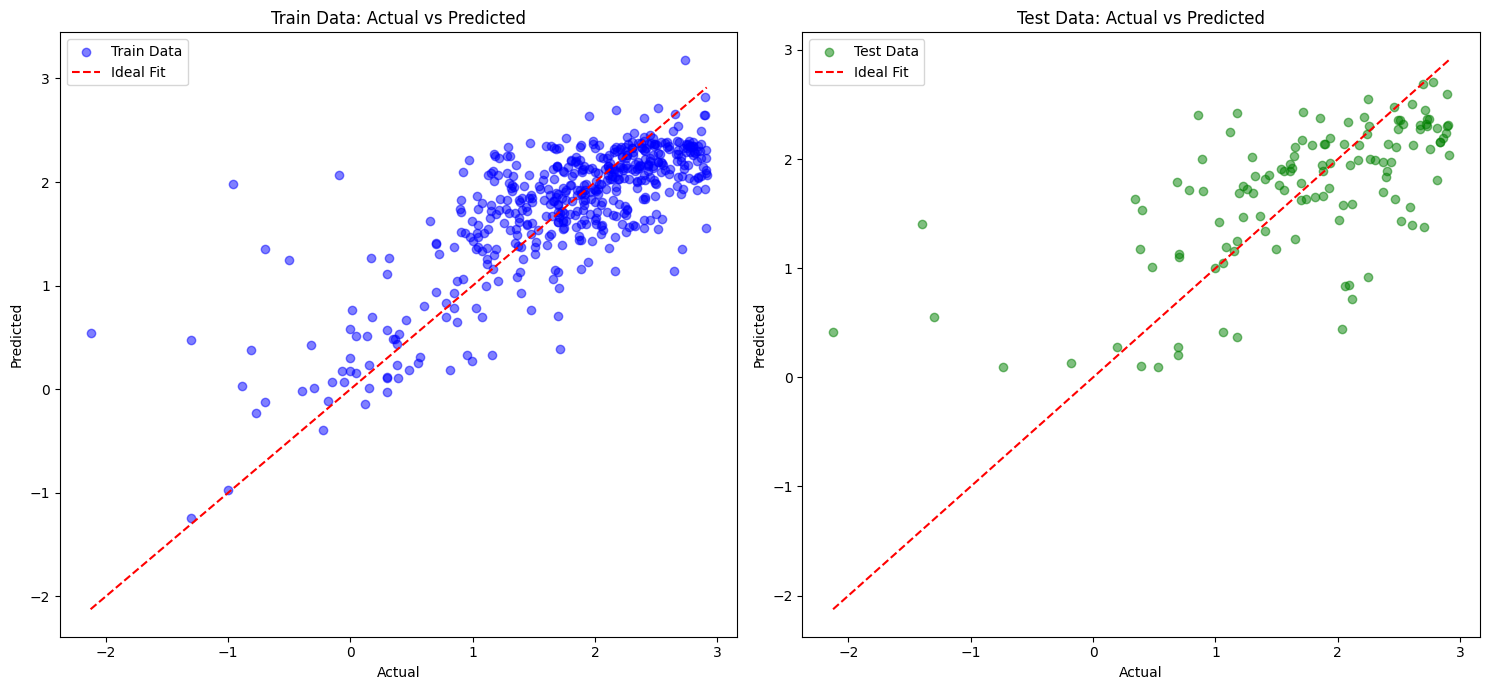

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# Plot Train Data
plt.scatter(train_label.numpy(), train_preds.numpy(), color='blue', alpha=0.5, label='Train Data')

# Plot Test Data
plt.scatter(test_label.numpy(), test_preds.numpy(), color='green', alpha=0.5, label='Test Data')

# Plot Ideal Fit Line
min_val = min(min(train_label.numpy()), min(test_label.numpy()))
max_val = max(max(train_label.numpy()), max(test_label.numpy()))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit')

# Labels and Title
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Train and Test Data)')
plt.legend()

plt.tight_layout()
plt.show()

# Визуализация полученых скрытых слоёв и узлов

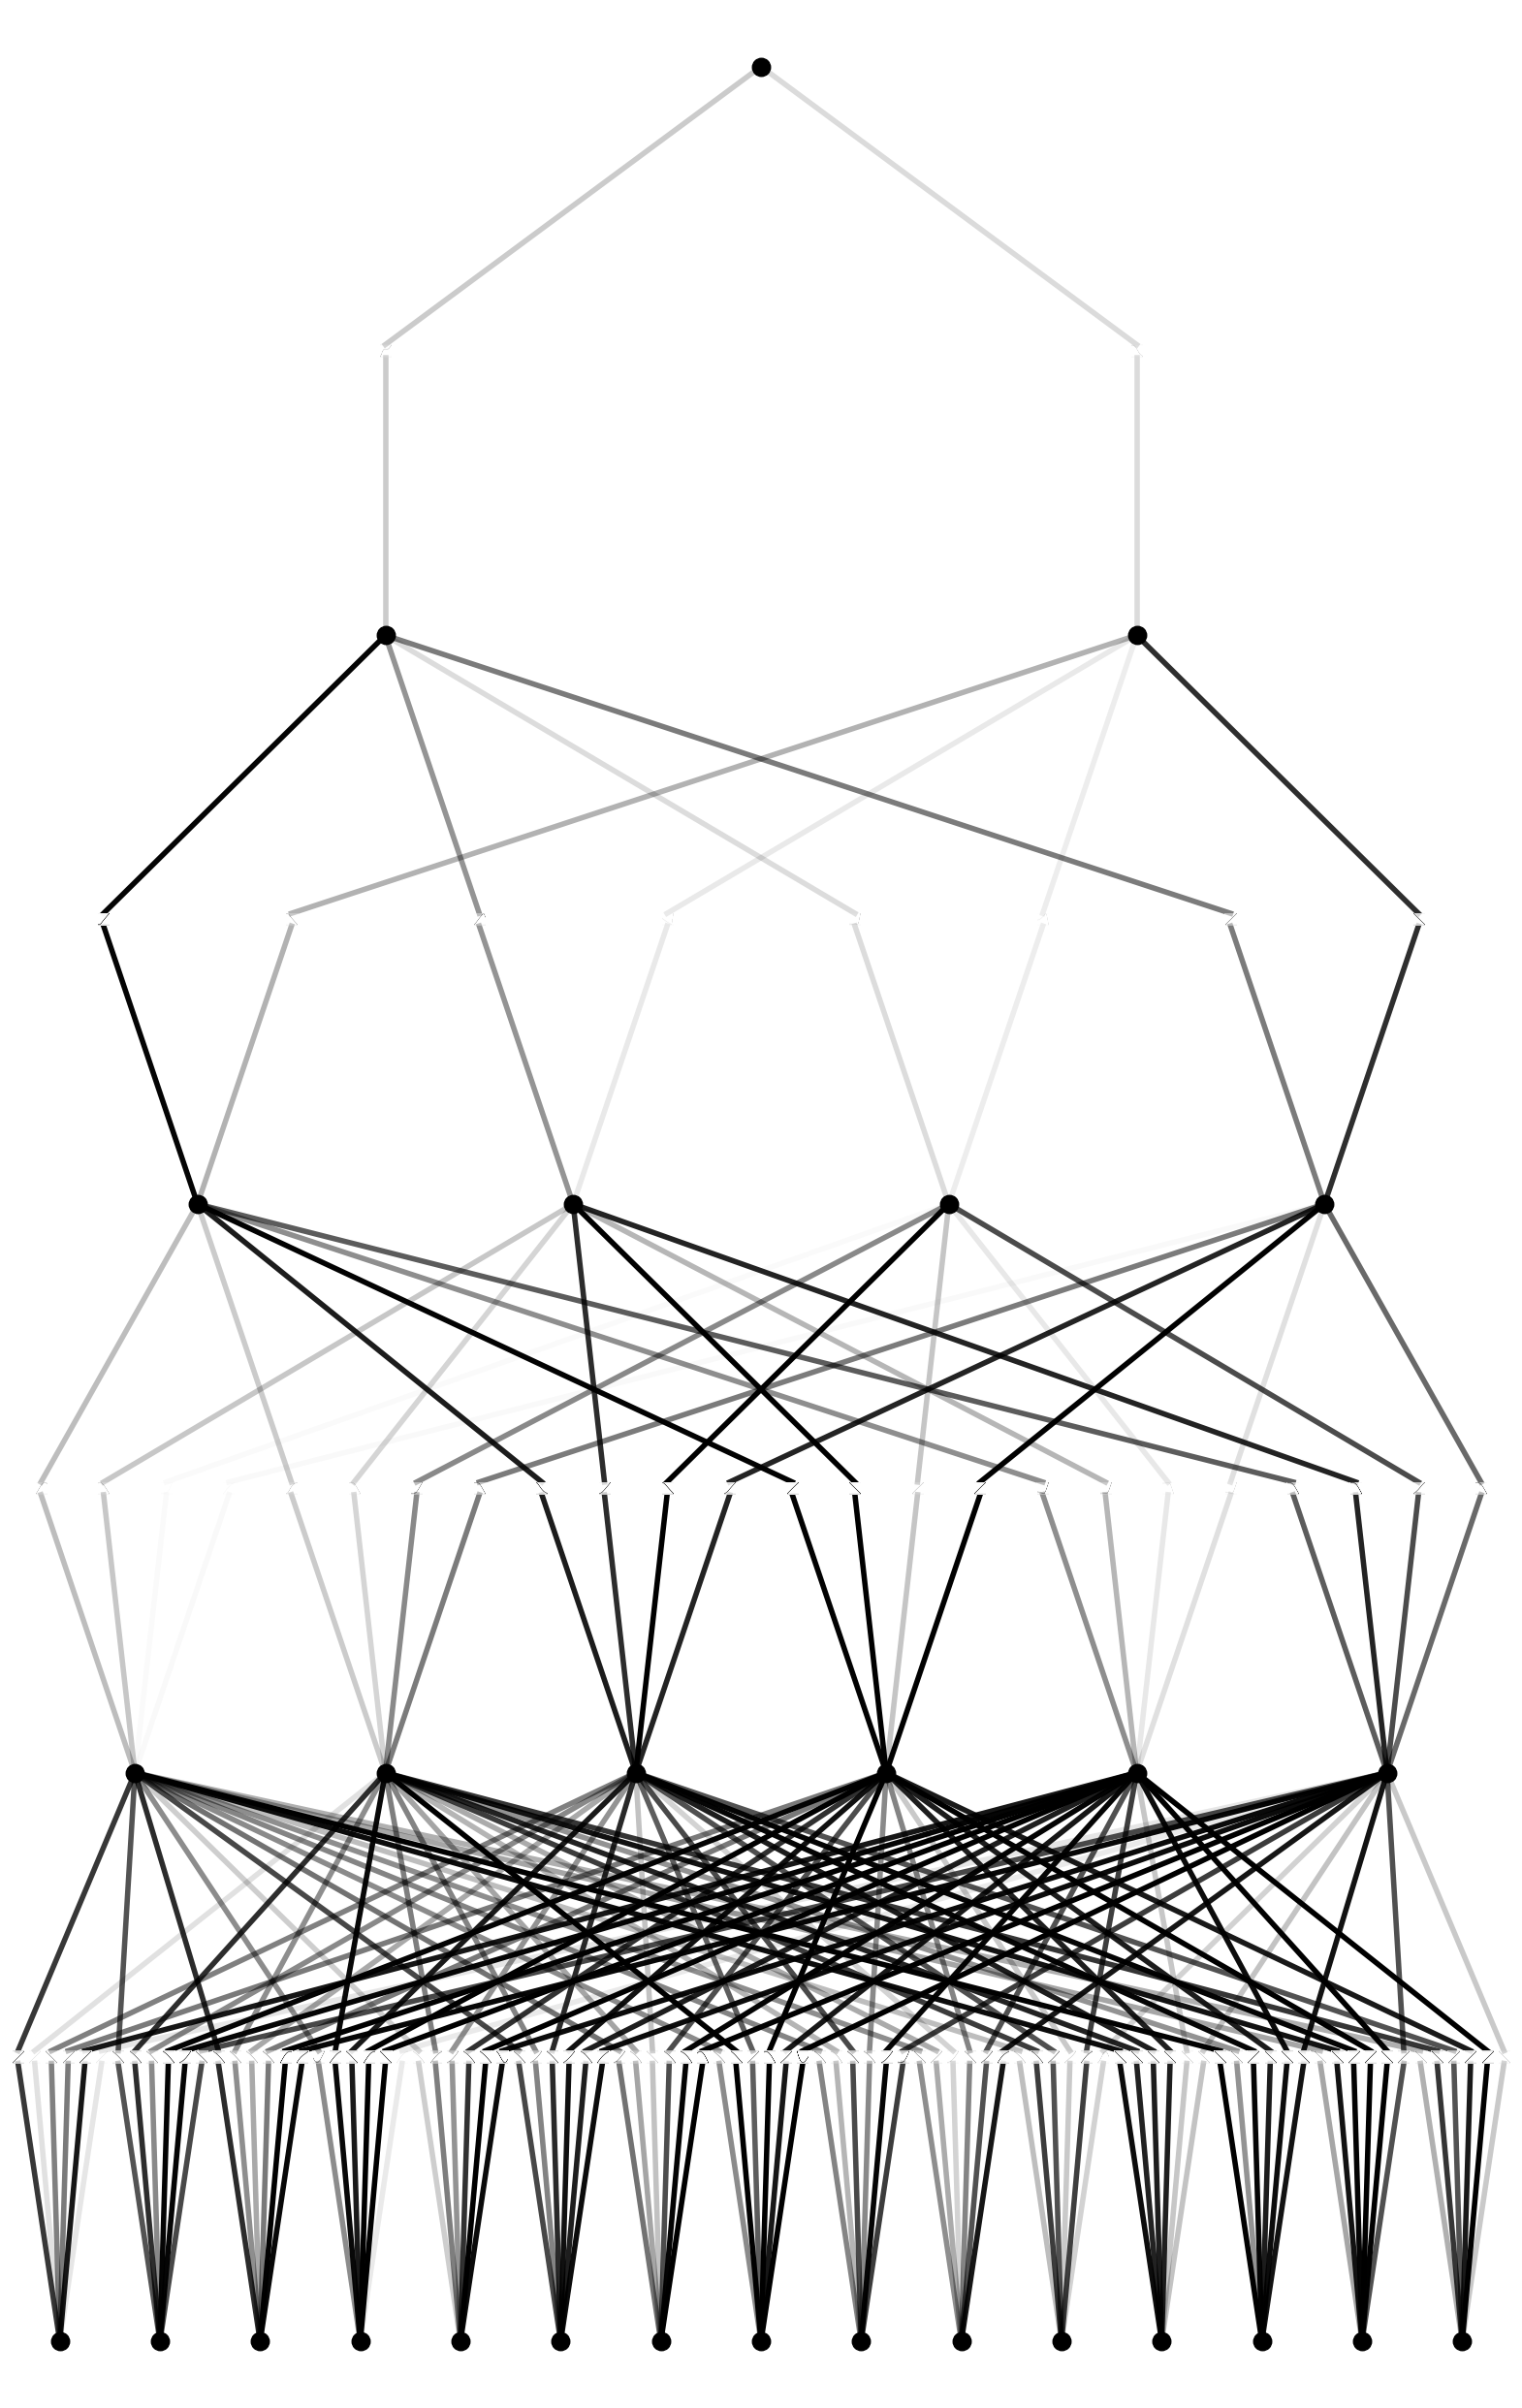

In [ ]:
#model.prune()
model.plot(scale=2)

# Symbolic Formulation

- Thus this is regression case, some of the users maybe want formulation of this model in order to see how model predicts
- This can be analyzed via **symbolic formulation**
- This process has good and bad norms:

1) Good: Approximate symbolic formulas can fit the data well within some tolerances and provide useful insights in some cases.

2) Bad: Exact and accurate formulas are difficult to find, especially when model generalization or precise calculations are required.

Also you can check it out this tutorial => https://kindxiaoming.github.io/pykan/Examples/Example_4_symbolic_regression.html

Here is related issue about appx. formulation's performance where also author of KAN replied => https://github.com/KindXiaoming/pykan/issues/111